The notebook is a comprehensive data analysis script that processes and merges multiple datasets related to patient trials, preparing the data for further modeling or evaluation. It begins by reading a Parquet file 'TrialGPT-Criterion-Annotations/data/train-00000-of-00001.parquet' into a DataFrame df_parquet, and a TSV file 'TrialGPT/dataset/sigir/qrels/test.tsv' into df_tsv. To facilitate merging, the TSV file's columns are renamed to match those in df_parquet (renaming 'query-id' to 'patient_id' and 'corpus-id' to 'trial_id'). The notebook performs data cleaning by trimming whitespace from string columns and examines unique values and distributions within columns to understand the data's structure. An inner merge on ['patient_id', 'trial_id'] results in df_joined, and the script identifies unmatched records to assess the completeness and integrity of the merge.

Subsequently, the notebook reads a JSON Lines file 'TrialGPT/dataset/sigir/queries.jsonl', which contains patient query data, and filters it to include only those patient IDs present in df_joined. This filtered dataset is saved for future use. A further merge combines the filtered queries with df_joined, producing df_final, which consolidates patient information, trial data, and associated scores. The notebook conducts statistical analyses on df_final, such as calculating the distribution of matching scores, aggregating statistics on the number of trials per patient, and examining the distinct criteria texts associated with patients. Visualizations, including histograms and bar plots, depict distributions of trials per patient and criteria per patient, aiding in identifying patterns or anomalies in the data.

In the later sections, the focus shifts to data sampling and preparation for detailed analysis. The script filters patients who have exactly two trials and a specific range of distinct criteria (between 15 and 25), randomly selecting five patients for an in-depth examination. Corresponding query data for these patients is saved to 'TrialGPT/dataset/sigir/mini_filtered_queries.jsonl'. Finally, the notebook reads and processes a JSON file containing trial rankings ('TrialGPT/results/trial_rankings/all_rankings.json'), flattens the nested JSON structure into a DataFrame, and provides summary statistics on the number of patients and trials. This prepares the data for subsequent analysis or modeling steps, ensuring that the dataset is well-understood and ready for advanced processing.

## Summary of the current work:

This notebook focuses on analyzing and comparing different eligibility assessments for clinical trials, involving patient data, trial information, and various eligibility labels. The main steps and analyses include:

1. Data Loading and Preprocessing:
   - Loaded multiple datasets: trial annotations, patient queries, trial corpus, and matching results.
   - Performed data cleaning, merging, and filtering operations to create comprehensive datasets.

2. Data Analysis:
   - Analyzed distributions of trials per patient and criteria per patient.
   - Examined the structure and content of various datasets, including patient summaries and trial criteria.

3. Eligibility Label Comparison:
   - Created a merged dataset combining information from multiple sources.
   - Compared three types of eligibility labels: expert-annotated, GPT-4 generated, and algorithm-predicted.
   - Used confusion matrices, F1 scores, and classification reports to evaluate the performance of different labeling methods.

4. Visualization:
   - Created various plots to visualize the distribution of scores, criteria, and performance metrics.

5. Detailed Comparison:
   - Generated tables highlighting discrepancies between different eligibility assessments.
   - Analyzed cases where predictions differed from expert annotations or GPT-4 assessments.

Contrast with the initial summary:

The initial summary at the top of the notebook described a data processing pipeline focused on merging and preparing datasets for modeling. It mentioned:
- Reading and processing Parquet and TSV files.
- Merging datasets based on patient and trial IDs.
- Basic statistical analyses and visualizations of the merged data.
- Sampling and filtering operations to create a subset of data for detailed analysis.

The current work goes significantly beyond this initial scope:
1. Depth of Analysis: While the initial summary focused on data preparation, the current work delves deep into comparing and analyzing different eligibility assessments.
2. Multiple Data Sources: The current analysis incorporates more data sources, including GPT-4 generated labels and algorithm predictions, which weren't mentioned in the initial summary.
3. Advanced Analytical Techniques: The notebook employs more sophisticated analytical methods, such as confusion matrices, F1 scores, and detailed classification reports.
4. Focus on Eligibility Assessment: The current work specifically targets the comparison of different methods for determining trial eligibility, which wasn't a focus in the initial summary.
5. Visualization and Interpretation: The notebook includes more advanced visualizations and interpretations of the results, providing deeper insights into the performance of different eligibility assessment methods.

In essence, while the initial summary described a data preparation process, the current work represents a comprehensive analysis of clinical trial eligibility assessments, comparing expert annotations with AI-generated predictions and exploring the nuances and discrepancies between these different approaches.

In [1]:
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Set pandas display options 
pd.set_option('display.max_rows', 1)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 300)

In [2]:
def clean_and_sort_imports(import_list):
    # Split each import statement into lines
    imports = import_list.split('\n')
    
    # Remove empty lines, strip whitespace, and remove duplicates
    unique_imports = list(dict.fromkeys(line.strip() for line in imports if line.strip()))
    
    # Sort imports by length, then alphabetically for imports of the same length
    sorted_imports = sorted(unique_imports, key=lambda x: (len(x), x))
    
    return sorted_imports

# Example usage:
imports = """
import pandas as pd
import pandas as pd
import pandas as pd
import pandas as pd
import json
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
"""

cleaned_sorted_imports = clean_and_sort_imports(imports)

# Print the cleaned and sorted imports
for imp in cleaned_sorted_imports:
    print(imp)

import os
import glob
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report


In [3]:
# Read the Parquet file
parquet_file = '../TrialGPT-Criterion-Annotations/data/train-00000-of-00001.parquet'
df_parquet = pd.read_parquet(parquet_file)

In [4]:
# if not pre downloaded use this below, or download from hf 
# df_parquet = pd.read_parquet("hf://datasets/ncbi/TrialGPT-Criterion-Annotations/data/train-00000-of-00001.parquet")
# https://huggingface.co/datasets/ncbi/TrialGPT-Criterion-Annotations

In [5]:
# Print both DataFrames
print("Parquet DataFrame:")
df_parquet

Parquet DataFrame:


,annotation_id,patient_id,note,trial_id,trial_title,criterion_type,criterion_text,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training
0,0,sigir-20141,"0. A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life.\n1. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, ...",NCT01397994,Study to Assess Efficacy of Nicorandil+Atenolol vs Atenolol in Treatment of Chronic Stable Angina.,inclusion,Patients of chronic stable angina with abnormal Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes.,"The patient note does not provide direct evidence of the patient having chronic stable angina or having undergone an Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes. However, the patient does present with symptoms of chest pain, which could be i...",Correct,"[0, 1, 2]","[0, 1, 2]",not enough information,not enough information,True


In [6]:
# Load the TSV file
tsv_file = 'dataset/sigir/qrels/test.tsv'
df_tsv = pd.read_csv(tsv_file, sep='\t', names=['query-id', 'corpus-id', 'score'])

In [7]:
# Display info about the DataFrame
print("\nDataFrame Info:")
print(df_tsv.info())

# Display basic statistics of the DataFrame
print("\nDataFrame Description:")
print(df_tsv.describe())

# Display value counts for each column
for column in df_tsv.columns:
    print(f"\nValue counts for {column}:")
    print(df_tsv[column].value_counts().head())

# # Optional: Save to CSV for easy viewing in spreadsheet software
# df_tsv.to_csv('test_tsv_data.csv', index=False)
# print("\nDataFrame saved to 'test_tsv_data.csv'")# Display the first few rows of the DataFrame

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
df_tsv.head()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3836 entries, 0 to 3835
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   query-id   3836 non-null   object
 1   corpus-id  3836 non-null   object
 2   score      3836 non-null   object
dtypes: object(3)
memory usage: 90.0+ KB
None

DataFrame Description:
      query-id corpus-id score
count     3836      3836  3836
...        ...       ...   ...

[4 rows x 3 columns]

Value counts for query-id:
query-id
sigir-20147    153
              ... 
Name: count, Length: 5, dtype: int64

Value counts for corpus-id:
corpus-id
NCT00455468    5
              ..
Name: count, Length: 5, dtype: int64

Value counts for score:
score
0    2733
     ... 
Name: count, Length: 4, dtype: int64
First few rows of the DataFrame:


,query-id,corpus-id,score
0,query-id,corpus-id,score


In [8]:
# Dictionary to store the results
column_stats = {}

# Loop through each column
for column in df_parquet.columns:
    # Get unique values
    unique_values = df_parquet[column].unique()
    
    # Convert to list and sort (if possible)
    try:
        unique_list = sorted(unique_values.tolist())
    except TypeError:
        # If sorting fails (e.g., for mixed types), just convert to list without sorting
        unique_list = unique_values.tolist()
    
    # Store in dictionary
    column_stats[f"{column}_list"] = unique_list
    
    # Print summary
    print(f"{column}:")
    print(f"  Number of unique values: {len(unique_list)}")
    print(f"  First few unique values: {unique_list[:5]}")  # Show first 5 values
    print()

# Now column_stats dictionary contains lists for each column
# You can access them like this: column_stats['patient_id_list']

# # Optional: Save to file
# import json
# with open('column_stats.json', 'w') as f:
#     json.dump(column_stats, f, indent=2)
# print("Results saved to column_stats.json")

annotation_id:
  Number of unique values: 1015
  First few unique values: [0, 1, 2, 3, 4]

patient_id:
  Number of unique values: 53
  First few unique values: ['sigir-20141', 'sigir-201410', 'sigir-201411', 'sigir-201412', 'sigir-201413']

note:
  Number of unique values: 53
  First few unique values: ['0. 64-year-old obese female with diagnosis of diabetes mellitus and persistently elevated HbA1c.\n1. She is reluctant to see a nutritionist and is not compliant with her diabetes medication or exercise.\n2. She complains of a painful skin lesion on the left lower leg.\n3. She has tried using topical lotions and creams but the lesion has increased in size and is now oozing.\n4. The patient will provide informed consent, and will comply with the trial protocol without any practical issues.', '0. A 10 year old child is brought to the emergency room complaining of myalgia, cough, and shortness of breath.\n1. Two weeks ago the patient was seen by his pediatrician for low-grade fever, abdomi

In [9]:
# Rename columns in df_tsv to match df_parquet
# This step ensures that the column names used for merging are consistent across both dataframes
df_tsv = df_tsv.rename(columns={'query-id': 'patient_id', 'corpus-id': 'trial_id'})

# Perform the join
# We're using a right join here, which keeps all rows from df_parquet and matching rows from df_tsv
# This is important because it ensures we don't lose any data from df_parquet, contains our main dataset
df_joined = pd.merge(df_tsv, df_parquet, on=['patient_id', 'trial_id'], how='right') 

# Display info about the joined DataFrame
# This gives us an overview of the resulting dataframe, including column names and data types
print("\nJoined DataFrame Info:")
print(df_joined.info())

# Display basic statistics of the joined DataFrame
# This provides summary statistics for numerical columns, helping us understand the data distribution
print("\nJoined DataFrame Description:")
print(df_joined.describe())

# Display the number of rows in each DataFrame
# This helps us verify if we've lost or gained any rows during the merge operation
print(f"\nNumber of rows in df_tsv: {len(df_tsv)}")
print(f"Number of rows in df_parquet: {len(df_parquet)}")
print(f"Number of rows in joined DataFrame: {len(df_joined)}")

# Extract unique patient IDs from the joined DataFrame
# This helps us understand how many distinct patients are in our dataset
distinct_patient_ids = df_joined['patient_id'].unique()

# Calculate and print the number of distinct patients
# This gives us a quick count of how many unique patients we're dealing with
num_distinct_patients = len(distinct_patient_ids)
print(f"Number of distinct patient_ids: {num_distinct_patients}")

# Convert unique patient IDs to a list and print them
# This allows us to see all unique patient IDs, which can be useful for debugging or further analysis
distinct_patient_ids_list = distinct_patient_ids.tolist()
print("\nDistinct patient_ids as a list:")
print(distinct_patient_ids_list)

# Display the entire joined DataFrame
# This allows us to see the structure and content of our merged data
df_joined


Joined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1015 non-null   object
 1   trial_id                 1015 non-null   object
 2   score                    997 non-null    object
 3   annotation_id            1015 non-null   int64 
 4   note                     1015 non-null   object
 5   trial_title              1015 non-null   object
 6   criterion_type           1015 non-null   object
 7   criterion_text           1014 non-null   object
 8   gpt4_explanation         1015 non-null   object
 9   explanation_correctness  1015 non-null   object
 10  gpt4_sentences           1015 non-null   object
 11  expert_sentences         1015 non-null   object
 12  gpt4_eligibility         1015 non-null   object
 13  expert_eligibility       1015 non-null   object
 14  training        

,patient_id,trial_id,score,annotation_id,note,trial_title,criterion_type,criterion_text,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training
0,sigir-20141,NCT01397994,1,0,"0. A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life.\n1. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, ...",Study to Assess Efficacy of Nicorandil+Atenolol vs Atenolol in Treatment of Chronic Stable Angina.,inclusion,Patients of chronic stable angina with abnormal Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes.,"The patient note does not provide direct evidence of the patient having chronic stable angina or having undergone an Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes. However, the patient does present with symptoms of chest pain, which could be i...",Correct,"[0, 1, 2]","[0, 1, 2]",not enough information,not enough information,True


In [10]:
# Read the JSONL file from the dataset
# This file is part of the TrialGPT dataset and contains query information
# The 'queries.jsonl' file likely includes patient information
jsonl_file = 'dataset/sigir/queries.jsonl'
queries = []

# Open the file and read it line by line
with open(jsonl_file, 'r') as file:
    for line in file:
        # Parse each line as a JSON object and append it to the queries list
        # This approach is memory-efficient for large files as it processes one line at a time
        queries.append(json.loads(line))

# Convert the list of dictionaries (parsed JSON objects) to a pandas DataFrame
# This transformation allows for easier data manipulation and analysis using pandas functions
df_queries = pd.DataFrame(queries)

# Display the entire DataFrame
# This allows us to inspect the structure and content of the queries data from the dataset
df_queries

,_id,text
0,sigir-20141,"A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is ..."


In [11]:
# Filter df_queries to keep only the _ids present in df_joined's patient_id
# This step ensures we only work with queries that have corresponding data in our joined dataset
df_queries_filtered = df_queries[df_queries['_id'].isin(df_joined['patient_id'])]

# Display information about the filtering process
# This helps us understand how many queries were kept and how many were removed
print(f"Total number of queries: {len(df_queries)}")
print(f"Number of queries after filtering: {len(df_queries_filtered)}")
print(f"Number of queries removed: {len(df_queries) - len(df_queries_filtered)}")

# Display the first few rows of the filtered queries DataFrame
# This allows us to inspect the structure and content of the filtered data
print("\nFirst few rows of filtered queries:")
print(df_queries_filtered.head())


# Total number of queries: 59
# Number of queries after filtering: 52
# # Number of queries removed: 7
# What this means:

#     The original queries.jsonl file contained information for 59 patients.
#     After filtering, we're left with 52 patients that have corresponding data in the df_joined DataFrame.
#     7 patients were removed during the filtering process.

# A "removed query" in this context refers to a patient entry that exists in the queries.jsonl file (which is part of the TrialGPT dataset for testing) but does not have a corresponding entry in the TrialGPT-Criterion-Annotations set (represented by df_joined).

# These removed queries are significant because:

#     They represent patients that are part of the testing dataset but not part of the annotation set.
#     This discrepancy could be intentional, possibly to test the model's performance on unseen data.
#     It highlights the difference between the full testing dataset and the subset that has detailed annotations.

# The filtering step ensures that we're working with a consistent set of patients across our different data sources. However, it's important to note that by removing these 7 queries, we might be excluding some test cases that were intended to evaluate the model's performance on patients not seen in the training data.

# This observation is crucial for understanding the scope of our analysis and any potential limitations in our evaluation process. It also underscores the importance of carefully considering how we handle data that appears in one dataset but not another when working with multiple related datasets.

Total number of queries: 59
Number of queries after filtering: 52
Number of queries removed: 7

First few rows of filtered queries:
            _id  \
0   sigir-20141   
..          ...   

                                                                                                                                                                                                                                                                                                           text  
0   A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is ...  
..                                                                                                                                                                                                    

# Importance of this step:

### don't run with min_to_run openAI branch need full queries.jsonl for qrels = GenericDataLoader

In [12]:
# Optional: Save filtered queries to a new JSONL file
# This step creates a new dataset that only includes patients with corresponding annotations
output_file = 'dataset/sigir/filtered_queries.jsonl'
with open(output_file, 'w') as file:
    for _, row in df_queries_filtered.iterrows():
        json.dump(row.to_dict(), file)
        file.write('\n')
print(f"\nFiltered queries saved to {output_file}")

# # Optional: Save filtered queries to CSV for easy viewing
# df_queries_filtered.to_csv('filtered_queries.csv', index=False)
# print("Filtered queries also saved to filtered_queries.csv")

# Importance of this step:
#     Data Consistency: By saving only the filtered queries, we ensure that our dataset aligns perfectly with the annotation data. This consistency is crucial for accurate model evaluation.
#     Resource Efficiency: As you correctly pointed out, we're avoiding unnecessary processing of data for which we don't have annotations. This saves computational resources and time.
#     Replication Focus: By using just the annotation data, we're focusing on replicating the results based on the subset of data that has been expertly annotated. This allows for a more direct comparison with the reported results.
#     Reducing Noise: Excluding patients without annotations eliminates potential noise or inconsistencies that could arise from trying to process or predict outcomes for patients lacking expert-labeled data.
# Why this approach is safe:
#     Data Integrity: We're not altering or manipulating the content of the queries, just selecting a subset. This preserves the integrity of the individual patient data.
#     Traceability: By creating a new file, we maintain a clear record of which queries were used in our analysis, making our process transparent and reproducible.
#     Original Data Preservation: The original dataset remains untouched, allowing us to always refer back to it if needed.
#     Controlled Environment: This approach creates a controlled dataset that matches exactly with our annotation data, reducing variables that could affect our ability to replicate the reported results.
#     Alignment with Best Practices: In machine learning and data science, it's common and often recommended to work with a clearly defined and consistent dataset, especially when trying to replicate results.
# By taking this approach, you're creating a more controlled environment for your analysis, which is crucial when attempting to replicate and verify reported results. It allows you to focus on the core task of eligibility assessment based on expert-annotated data, without introducing potential confounding factors from unannotated cases.


Filtered queries saved to dataset/sigir/filtered_queries.jsonl


In [13]:
# Display the number of unique _ids in the filtered queries
# This helps us understand how many distinct patients we have in our filtered query dataset
print(f"\nNumber of unique _ids in filtered queries: {df_queries_filtered['_id'].nunique()}")

# Display the number of unique patient_ids in df_joined
# This shows how many distinct patients we have in our joined dataset
print(f"Number of unique patient_ids in df_joined: {df_joined['patient_id'].nunique()}")

# Find patient_ids in df_joined that are not in df_queries_filtered
# This identifies any patients in the joined dataset that don't have corresponding queries
extra_ids = set(df_joined['patient_id']) - set(df_queries_filtered['_id'])
print(f"\nNumber of patient_ids in df_joined not present in filtered queries: {len(extra_ids)}")

# Check for any _ids in filtered queries not present in df_joined's patient_id
# This identifies any queries that don't have corresponding patient data in the joined dataset
missing_ids = set(df_queries_filtered['_id']) - set(df_joined['patient_id'])
print(f"\nNumber of _ids in filtered queries not present in df_joined: {len(missing_ids)}")
if missing_ids:
    print("Sample of missing _ids:", list(missing_ids)[:5])

# If there are extra IDs in df_joined, print them and their corresponding rows
if extra_ids:
    print("Extra patient_ids in df_joined:")
    for id in extra_ids:
        print(id)
    
    # Retrieve and print the full rows for these extra IDs in df_joined
    extra_rows = df_joined[df_joined['patient_id'].isin(extra_ids)]
    print("\nFull rows for extra IDs in df_joined:")
    print(extra_rows)
else:
    print("No extra patient_ids found in df_joined.")

# Double-check the counts to ensure consistency
print(f"\nConfirming counts:")
print(f"df_queries_filtered '_id' count: {df_queries_filtered['_id'].count()}")
print(f"df_joined 'patient_id' count: {df_joined['patient_id'].count()}")


# Number of unique _ids in filtered queries: 52
# Number of unique patient_ids in df_joined: 53

# Number of patient_ids in df_joined not present in filtered queries: 1

# Number of _ids in filtered queries not present in df_joined: 0
# Extra patient_ids in df_joined:
# sigir-201426
# Confirming counts:
# df_queries_filtered '_id' count: 52
# df_joined 'patient_id' count: 1015
# ```

# These counts indeed indicate that we have one more annotated patient in the TrialGPT-Criterion-Annotations dataset than we do in the filtered queries.jsonl file. Here's the detailed explanation:

# 1. Unique Patients Discrepancy:
#    - We have 52 unique patients in the filtered queries dataset.
#    - We have 53 unique patients in the joined dataset (df_joined).
#    - This immediately shows us that there's one extra patient in the annotations.

# 2. Extra Patient Identification:
#    - The code identified one patient ID (sigir-201426) that exists in df_joined but not in the filtered queries.
#    - This confirms that we have an additional annotated patient that doesn't have a corresponding query in the queries.jsonl file.

# 3. No Missing Queries:
#    - There are 0 query IDs that exist in the filtered queries but not in df_joined.
#    - This means all the patients in our queries dataset have corresponding annotations.

# 4. Total Annotation Count:
#    - The df_joined 'patient_id' count is 1015, which likely represents the total number of annotations (not unique patients).
#    - This suggests that on average, we have about 19 annotations per patient (1015 / 53 ≈ 19).

# 5. Consistency in Filtered Queries:
#    - The filtered queries dataset has 52 entries, matching the number of unique IDs.
#    - This indicates that each patient in the queries dataset has exactly one query entry.

# Implications:

# 1. Data Completeness: We have more annotated data than query data.

# 2. Potential for Analysis: The extra patient (sigir-201426) in the annotations dataset provides an opportunity to examine why this discrepancy exists. It could be due to:
#    - An intentional addition for testing purposes.
#    - A data collection or processing error.
#    - A patient that was annotated but whose query was later removed for some reason.

# 3. Data Integrity: The fact that all filtered queries have corresponding annotations is a positive sign for data integrity.

# 4. Comprehensive Annotations: With an average of 19 annotations per patient, we have a rich dataset for analysis, likely covering multiple criteria or trials per patient.

# This discrepancy, while small, is important to note for several reasons:
# - It ensures transparency in your data processing pipeline.
# - It may affect how you calculate certain statistics or perform your analysis.
# - It provides an opportunity to investigate why this extra patient exists in the annotations and whether it should be included or excluded in further analysis.

# Understanding these nuances in your dataset is crucial for accurate analysis and interpretation of results, especially when trying to replicate or validate previous findings.


Number of unique _ids in filtered queries: 52
Number of unique patient_ids in df_joined: 53

Number of patient_ids in df_joined not present in filtered queries: 1

Number of _ids in filtered queries not present in df_joined: 0
Extra patient_ids in df_joined:
sigir-201426

Full rows for extra IDs in df_joined:
       patient_id     trial_id score  annotation_id  \
481  sigir-201426  NCT00373048   NaN            481   
..            ...          ...   ...            ...   

                                                                                                                                                                                                                                                                                                            note  \
481  0. A group of 14 humanitarian service workers is preparing a trip to the Amazon Rainforest region in Brazil.\n1. All the members of the group have traveled on multiple occasions and have up-to-date vaccine cer

Number of rows in final joined DataFrame: 997
Number of unique patients: 52
Number of unique trials: 101

Count of scores:
score
1    598
    ... 
Name: count, Length: 2, dtype: int64

Percentage of each score:
score
1    59.97994
       ...   
Name: count, Length: 2, dtype: float64

Basic statistics of scores:
count    997
        ... 
Name: score, Length: 4, dtype: object

Score distribution plot saved as 'score_distribution.png'


,patient_id,text,trial_id,score,annotation_id,note,trial_title,criterion_type,criterion_text,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training
0,sigir-20141,"A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is ...",NCT01397994,1,0,"0. A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life.\n1. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, ...",Study to Assess Efficacy of Nicorandil+Atenolol vs Atenolol in Treatment of Chronic Stable Angina.,inclusion,Patients of chronic stable angina with abnormal Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes.,"The patient note does not provide direct evidence of the patient having chronic stable angina or having undergone an Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes. However, the patient does present with symptoms of chest pain, which could be i...",Correct,"[0, 1, 2]","[0, 1, 2]",not enough information,not enough information,True


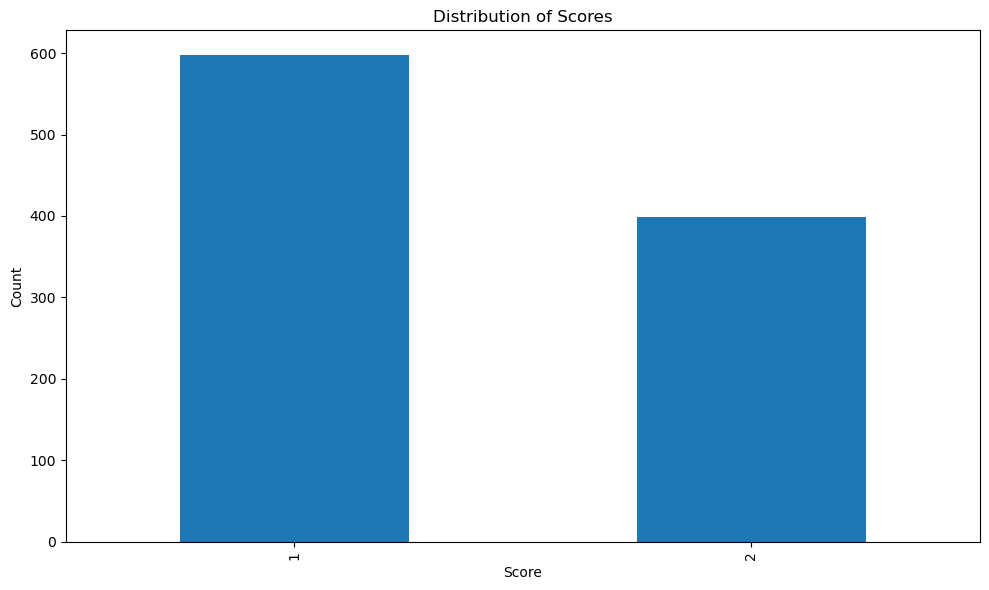

In [14]:
# Rename the '_id' column in df_queries_filtered to 'patient_id' for consistency in the join operation
df_queries_filtered = df_queries_filtered.rename(columns={'_id': 'patient_id'})

# Perform an inner join between df_queries_filtered and df_joined on the 'patient_id' column
# This ensures we only keep rows where patient_id exists in both dataframes
df_final = pd.merge(df_queries_filtered, df_joined, on='patient_id', how='inner')

# Display basic information about the joined DataFrame
print(f"Number of rows in final joined DataFrame: {len(df_final)}")
print(f"Number of unique patients: {df_final['patient_id'].nunique()}")
print(f"Number of unique trials: {df_final['trial_id'].nunique()}")

# Count the occurrences of each score value
score_counts = df_final['score'].value_counts().sort_index()
print("\nCount of scores:")
print(score_counts)

# Calculate the percentage distribution of scores
score_percentages = (score_counts / len(df_final)) * 100
print("\nPercentage of each score:")
print(score_percentages)

# Compute and display basic statistical measures of the scores
print("\nBasic statistics of scores:")
print(df_final['score'].describe())

# Visualize the distribution of scores
plt.figure(figsize=(10, 6))
score_counts.plot(kind='bar')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('score_distribution.png')  # Uncomment to save the plot
print("\nScore distribution plot saved as 'score_distribution.png'")

# Display the entire final joined DataFrame
df_final


# Number of rows in final joined DataFrame: 997
# Number of unique patients: 52
# Number of unique trials: 101

# Count of scores:
# score
# 1    598
# 2    399
# Name: count, dtype: int64

# Percentage of each score:
# score
# 1    59.97994
# 2    40.02006
# Name: count, dtype: float64

# Basic statistics of scores:
# count     997
# unique      2
# top         1
# freq      598
# Name: score, dtype: object


# 1. 997 rows: This number represents the total patient-trial combinations in our final dataset. It's less than the 1015 we saw earlier because:
#    - We filtered out the one patient (sigir-201426) that was in the annotations but not in the queries.
#    - The inner join operation only kept rows where patient IDs existed in both the filtered queries and the joined dataset.

# 2. 52 unique patients: This matches exactly with the number of unique patients we had in our filtered queries dataset. It confirms that we've successfully maintained all the patients from our queries in the final dataset.

# 3. 101 unique trials: This shows how many different clinical trials are represented in our dataset. Each patient might be evaluated for multiple trials.

# 4. Score distribution:
#    - We only have two score values: 1 and 2.
#    - Score 1 appears 598 times (59.98% of the cases)
#    - Score 2 appears 399 times (40.02% of the cases)

# This distribution tells us that our dataset is slightly imbalanced, with more instances of score 1 than score 2. In the context of clinical trial eligibility, these scores likely represent different levels of eligibility or relevance.

# The fact that we have 997 rows (patient-trial combinations) for 52 patients means that, on average, each patient is evaluated for about 19 trials (997 / 52 ≈ 19.17). This aligns with our earlier observation about the number of annotations per patient.


Distribution of trials per patient:
trial_id
1    1
    ..
Name: count, Length: 2, dtype: int64

Patients with the most trials (2):
['sigir-20141', 'sigir-201410', 'sigir-201411', 'sigir-201412', 'sigir-201413', 'sigir-201414', 'sigir-201415', 'sigir-201416', 'sigir-201417', 'sigir-201418', 'sigir-201419', 'sigir-20142', 'sigir-201420', 'sigir-201421', 'sigir-201422', 'sigir-201423', 'sigir-201424', 'sigir-201425', 'sigir-201427', 'sigir-201429', 'sigir-20143', 'sigir-201430', 'sigir-20144', 'sigir-20145', 'sigir-20146', 'sigir-20147', 'sigir-20148', 'sigir-20149', 'sigir-20151', 'sigir-201510', 'sigir-201511', 'sigir-201512', 'sigir-201513', 'sigir-201514', 'sigir-201515', 'sigir-201516', 'sigir-201517', 'sigir-201518', 'sigir-201519', 'sigir-20152', 'sigir-201520', 'sigir-201521', 'sigir-201522', 'sigir-201523', 'sigir-201524', 'sigir-20153', 'sigir-20154', 'sigir-20155', 'sigir-20156', 'sigir-20157', 'sigir-20158']

Patients with the least trials (1):
['sigir-20159']
Statistics of 

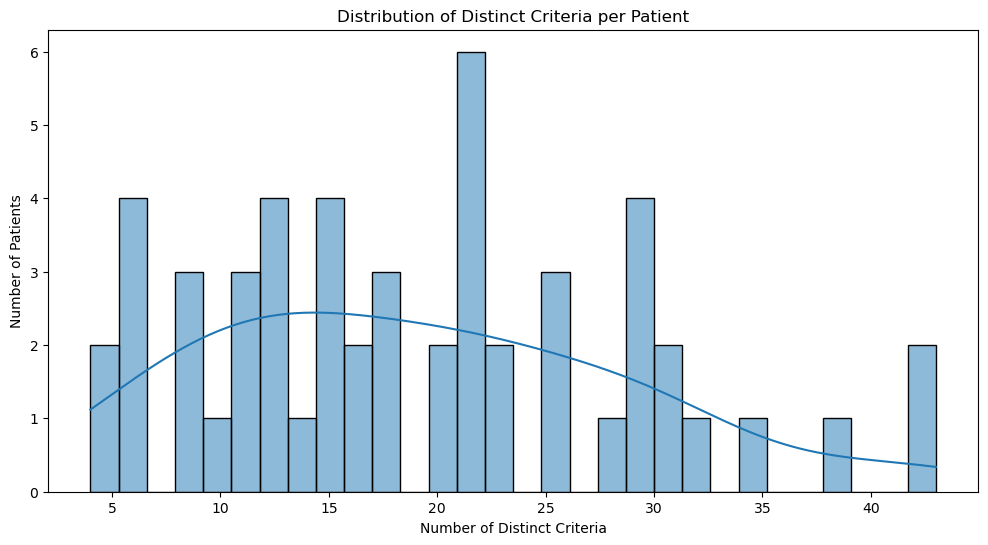

In [15]:
# Count the number of unique trials for each patient
trials_per_patient = df_final.groupby('patient_id')['trial_id'].nunique().sort_values(ascending=False)

# Display the distribution of trials per patient
print("\nDistribution of trials per patient:")
print(trials_per_patient.value_counts().sort_index())

# Identify patients with the most and least trials
max_trials = trials_per_patient.max()
min_trials = trials_per_patient.min()

# Display patients with the maximum number of trials
print(f"\nPatients with the most trials ({max_trials}):")
print(trials_per_patient[trials_per_patient == max_trials].index.tolist())

# Display patients with the minimum number of trials
print(f"\nPatients with the least trials ({min_trials}):")
print(trials_per_patient[trials_per_patient == min_trials].index.tolist())

# Add the number of trials for each patient back to df_final
df_final['num_trials'] = df_final['patient_id'].map(trials_per_patient)

# Count the number of distinct criteria texts for each patient
criteria_per_patient = df_final.groupby('patient_id')['criterion_text'].nunique().sort_values(ascending=False)

# Display basic statistics of the number of distinct criteria per patient
print("Statistics of distinct criteria per patient:")
print(criteria_per_patient.describe())

# Display the distribution of distinct criteria per patient
print("\nDistribution of distinct criteria per patient:")
print(criteria_per_patient.value_counts().sort_index())

# Calculate and display the percentage distribution of distinct criteria per patient
percentage_distribution = (criteria_per_patient.value_counts().sort_index() / len(criteria_per_patient)) * 100
print("\nPercentage distribution of distinct criteria per patient:")
print(percentage_distribution)

# Visualize the distribution of distinct criteria per patient
plt.figure(figsize=(12, 6))
sns.histplot(criteria_per_patient, kde=True, bins=30)
plt.title('Distribution of Distinct Criteria per Patient')
plt.xlabel('Number of Distinct Criteria')
plt.ylabel('Number of Patients')
# plt.savefig('criteria_per_patient_distribution.png')
# plt.close()
print("\nDistribution plot saved as 'criteria_per_patient_distribution.png'")

In [16]:
# Create a summary DataFrame
summary_df = pd.DataFrame({
    'num_criteria': criteria_per_patient.value_counts().sort_index().index,
    'num_patients': criteria_per_patient.value_counts().sort_index().values,
    'percentage': percentage_distribution.values
})

# Display the summary DataFrame
print("\nSummary of distinct criteria per patient:")
print(summary_df)

# # Save the summary to a CSV file
# summary_df.to_csv('criteria_per_patient_summary.csv', index=False)
# print("\nSummary saved to 'criteria_per_patient_summary.csv'")

# Identify patients with the most and least distinct criteria
max_criteria = criteria_per_patient.max()
min_criteria = criteria_per_patient.min()

print(f"\nPatients with the most distinct criteria ({max_criteria}):")
print(criteria_per_patient[criteria_per_patient == max_criteria].index.tolist())

print(f"\nPatients with the least distinct criteria ({min_criteria}):")
print(criteria_per_patient[criteria_per_patient == min_criteria].index.tolist())

# Optional: If you want to add this information back to df_final
df_final['num_distinct_criteria'] = df_final['patient_id'].map(criteria_per_patient)

# Display the first few rows of the updated df_final
print("\nFirst few rows of df_final with num_distinct_criteria added:")
print(df_final.head())

# # Save the updated df_final
# df_final.to_csv('df_final_with_criteria_counts.csv', index=False)
# print("\nUpdated df_final saved to 'df_final_with_criteria_counts.csv'")

# Additional analysis: Most common criteria texts
top_criteria = df_final['criterion_text'].value_counts().head(10)
print("\nTop 10 most common criteria texts:")
print(top_criteria)


Summary of distinct criteria per patient:
    num_criteria  num_patients  percentage
0              4             1    1.923077
..           ...           ...         ...

[27 rows x 3 columns]

Patients with the most distinct criteria (43):
['sigir-20144']

Patients with the least distinct criteria (4):
['sigir-20149']

First few rows of df_final with num_distinct_criteria added:
     patient_id  \
0   sigir-20141   
..          ...   

                                                                                                                                                                                                                                                                                                           text  \
0   A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanie

In [17]:
df_final

,patient_id,text,trial_id,score,annotation_id,note,trial_title,criterion_type,criterion_text,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training,num_trials,num_distinct_criteria
0,sigir-20141,"A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is ...",NCT01397994,1,0,"0. A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life.\n1. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, ...",Study to Assess Efficacy of Nicorandil+Atenolol vs Atenolol in Treatment of Chronic Stable Angina.,inclusion,Patients of chronic stable angina with abnormal Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes.,"The patient note does not provide direct evidence of the patient having chronic stable angina or having undergone an Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes. However, the patient does present with symptoms of chest pain, which could be i...",Correct,"[0, 1, 2]","[0, 1, 2]",not enough information,not enough information,True,2,31


In [18]:
# Filter the DataFrame to select patients with exactly 2 trials and between 15-25 distinct criteria
filtered_df = df_final[
    (df_final['num_trials'] == 2) & 
    (df_final['num_distinct_criteria'].between(15, 25))
].drop_duplicates('patient_id')

# Count how many patients meet these criteria
num_matching_patients = filtered_df['patient_id'].nunique()
print(f"Number of patients meeting the criteria: {num_matching_patients}")

sampsto = 5  # Number of patients to sample

# If we have at least 'sampsto' patients meeting the criteria, randomly select that many
if num_matching_patients >= sampsto:
    # Randomly select 'sampsto' patients
    selected_patients = random.sample(filtered_df['patient_id'].unique().tolist(), sampsto)
    
    # Print details of the selected patients
    print("\nRandomly selected patient_ids:")
    for i, patient_id in enumerate(selected_patients, 1):
        patient_data = filtered_df[filtered_df['patient_id'] == patient_id].iloc[0]
        print(f"{i}. patient_id: {patient_id}")
        print(f"   num_trials: {patient_data['num_trials']}")
        print(f"   num_distinct_criteria: {patient_data['num_distinct_criteria']}")
        print()

    # Create a new DataFrame with all data for these selected patients
    selected_df = df_final[df_final['patient_id'].isin(selected_patients)]

else:
    print("Not enough patients meet the criteria. Please adjust the filter conditions.")

# Filter df_queries to keep only the _ids present in selected_df's patient_id
df_queries_filtered = df_queries[df_queries['_id'].isin(selected_df['patient_id'])]

# Display information about the filtering process
print(f"Total number of queries: {len(df_queries)}")
print(f"Number of queries after filtering: {len(df_queries_filtered)}")
print(f"Number of queries removed: {len(df_queries) - len(df_queries_filtered)}")

# Save filtered queries to a new JSONL file
output_file = 'dataset/sigir/mini_filtered_queries.jsonl'
with open(output_file, 'w') as file:
    for _, row in df_queries_filtered.iterrows():
        json.dump(row.to_dict(), file)
        file.write('\n')
print(f"\nFiltered queries saved to {output_file}")

# Verify the number of queries in the saved file
print(f"\nNumber of queries in the JSONL file: {sum(1 for line in open(output_file))}")


# 1. Patient Selection:
#    - Filters patients based on specific criteria (2 trials and 15-25 distinct criteria).
#    - Randomly selects a subset of these patients for further analysis.

# 2. Data Extraction:
#    - Creates a new DataFrame (selected_df) containing all data for the selected patients.

# 3. Query Filtering:
#    - Filters the original queries dataset to include only the selected patients.

# 4. Data Saving:
#    - Saves the filtered queries to a new JSONL file.

# 5. Verification:
#    - Checks the number of queries in the saved file to ensure data integrity.

# This process is crucial for several reasons:
# - It creates a manageable subset of data for detailed analysis or testing.
# - The selection criteria ensure that the chosen patients have a similar level of complexity (in terms of trials and criteria), which can be important for fair comparisons or model testing.
# - Saving this subset as a separate file allows for easier replication of analyses or tests.
# - The random selection helps to avoid bias that might come from manually selecting patients.

# The verification steps throughout (counting patients, queries, etc.) are essential for ensuring that the data manipulation processes have worked as expected and that the resulting dataset matches our intentions.

# This approach of creating a smaller, well-defined subset of the data is often used in machine learning and data analysis to create test sets, perform detailed case studies, or to create manageable datasets for initial model development and testing.

Number of patients meeting the criteria: 21

Randomly selected patient_ids:
1. patient_id: sigir-20147
   num_trials: 2
   num_distinct_criteria: 17

2. patient_id: sigir-201523
   num_trials: 2
   num_distinct_criteria: 25

3. patient_id: sigir-201521
   num_trials: 2
   num_distinct_criteria: 21

4. patient_id: sigir-201411
   num_trials: 2
   num_distinct_criteria: 15

5. patient_id: sigir-201517
   num_trials: 2
   num_distinct_criteria: 15

Total number of queries: 59
Number of queries after filtering: 5
Number of queries removed: 54

Filtered queries saved to dataset/sigir/mini_filtered_queries.jsonl

Number of queries in the JSONL file: 5


In [19]:
# Read the corpus.jsonl file
# corpus.jsonl contains detailed information about clinical trials
# Each line in this file is a JSON object representing a single trial
# The structure includes fields like '_id' (trial ID), 'title', 'text', and 'metadata'
corpus_file = 'dataset/sigir/corpus.jsonl'

# Use pandas to read the JSONL file
# The 'lines=True' parameter tells pandas to read the file as JSON Lines format
# where each line is a separate JSON object
df_corpus = pd.read_json(corpus_file, lines=True)

# Display the entire DataFrame
df_corpus

# Note on corpus.jsonl structure:
# Each entry in corpus.jsonl looks like this:
# {
#   "_id": "NCT01520155",
#   "title": "CArdiovascular Risk Assessment STudy in Lupus Erythemathodes (CASTLE)",
#   "text": "Summary: The key of this prospective study is to identify...",
#   "metadata": {
#     "brief_title": "CArdiovascular Risk Assessment STudy in Lupus Erythemathodes (CASTLE)",
#     "phase": "",
#     "drugs": "",
#     "drugs_list": [],
#     "diseases": "['Systemic Lupus Erythematosus']",
#     "diseases_list": ["Systemic Lupus Erythematosus"],
#     "enrollment": "90.0",
#     "inclusion_criteria": "inclusion criteria: \n\n Patients with systemic Lupus erythematosus \n\n ",
#     "exclusion_criteria": ": \n\n Patients without systemic Lupus erythematosus",
#     "brief_summary": "The key of this prospective study is to identify..."
#   }
# }

,_id,title,text,metadata
0,NCT00995306,Evaluating the Safety and Efficacy Civamide in Osteoarthritis (OA) of the Knee(s),Summary: To evaluate the safety and efficacy of Civamide Cream 0.075% as a treatment of the signs and symptoms associated with osteoarthritis of the knee.\nInclusion criteria: inclusion criteria: \n\n Subject voluntarily agrees to participate in this study and signs an IRB-approved informed cons...,"{'brief_title': 'Evaluating the Safety and Efficacy Civamide in Osteoarthritis (OA) of the Knee(s)', 'phase': 'Phase 3', 'drugs': '['Civamide (Zucapsaicin)']', 'drugs_list': ['Civamide (Zucapsaicin)'], 'diseases': '['Osteoarthritis of the Knee']', 'diseases_list': ['Osteoarthritis of the Knee'],..."


In [20]:

# Filter the corpus to include only the trials present in df_final
# This step ensures we only keep trials that are relevant to our analysis
df_corpus_filtered = df_corpus[df_corpus['_id'].isin(df_final['trial_id'])]

# Display the filtered corpus DataFrame
df_corpus_filtered

# Save the filtered corpus to 'corpus_mini.jsonl'
# This creates a smaller, focused dataset for further analysis
output_file = 'dataset/sigir/corpus_mini.jsonl'
df_corpus_filtered.to_json(output_file, orient='records', lines=True)

print(f"Filtered corpus saved to {output_file}")


# Why this filtering is safe and prevents unnecessary calculation:

# 1. Data Relevance:
#    - By filtering the corpus to include only trials present in df_final, we ensure that we're working with only the relevant trials for our analysis.
#    - This aligns the corpus data with the TrialGPT-Criterion-Annotations dataset, maintaining consistency across our datasets.

# 2. Computational Efficiency:
#    - Reducing the size of the corpus eliminates the need to process trials that are not part of our analysis scope.
#    - This can significantly reduce computation time and resource usage in subsequent steps, especially if the original corpus is large.

# 3. Focus on Annotated Data:
#    - By keeping only the trials that correspond to the TrialGPT-Criterion-Annotations dataset, we ensure that all trials in our filtered corpus have associated annotations.
#    - This alignment is crucial for accurate analysis and model training, as we have expert-annotated data for these trials.

# 4. Preventing Noise:
#    - Removing trials not present in the annotation dataset eliminates potential noise or irrelevant data that could skew our analysis or model performance.

# 5. Consistency in Replication:
#    - This filtering step ensures that we're working with the exact set of trials that were part of the original study's annotated dataset.
#    - This is crucial for accurately replicating and validating the results of the original study.

# 6. Storage Efficiency:
#    - Saving a smaller, filtered corpus (corpus_mini.jsonl) reduces storage requirements and makes the dataset more manageable for sharing or further processing.

# 7. Ethical Considerations:
#    - By focusing only on trials with associated annotations, we're ensuring that all data used in our analysis has been properly vetted and annotated by experts.

# 8. Reproducibility:
#    - This filtered corpus, along with the other filtered datasets, creates a well-defined, reproducible dataset for your analysis.

# In essence, this filtering step is not just safe but also highly beneficial. It streamlines your dataset, focuses on the most relevant information, and aligns perfectly with the annotated data you're working with. 
# This approach ensures that your analysis is based on a consistent, well-defined set of trials, which is crucial for the integrity and reliability of your results in the clinical trial eligibility assessment task.

Filtered corpus saved to dataset/sigir/corpus_mini.jsonl


# filter pre made retrieved_trials to just those in annotation 

In [21]:
# Read the JSON file containing pre-compiled retrieved trials
# This file is part of the original repo and represents their data
with open('dataset/sigir/retrieved_trials.json', 'r') as file:
    data = json.load(file)

# Create a set of filtered NCTIDs from our previously filtered corpus
# This set will be used to filter the retrieved trials
filtered_nctids = set(df_corpus_filtered['_id'].tolist())

# Define a function to filter trials based on the filtered NCTIDs
def filter_trials(trials):
    return [trial for trial in trials if trial['NCTID'] in filtered_nctids]

# Filter the data while maintaining the original structure
filtered_data = []
for entry in data:
    filtered_entry = entry.copy()
    for key in ['0', '1', '2']:  # These keys likely represent different retrieval methods or rankings
        if key in filtered_entry:
            filtered_entry[key] = filter_trials(filtered_entry[key])
    
    # Keep the entry even if all lists are empty to maintain patient records
    filtered_data.append(filtered_entry)

# Save the filtered data to a new JSON file
with open('dataset/sigir/retrieved_trials_mini.json', 'w') as file:
    json.dump(filtered_data, file, indent=2)

# Define a function to flatten the hierarchical data structure for easier processing
def flatten_data(entry):
    flattened = []
    for key in ['0', '1', '2']:
        if key in entry and isinstance(entry[key], list):
            for item in entry[key]:
                item['patient_id'] = entry['patient_id']
                item['patient'] = entry['patient']
                flattened.append(item)
    return flattened

# Flatten the filtered data and convert it to a DataFrame for further analysis
flattened_data = [item for entry in filtered_data for item in flatten_data(entry)]
df_filtered = pd.DataFrame(flattened_data)
df_filtered

# This code block is crucial for several reasons:

# 1. Data Alignment: It aligns the pre-compiled retrieved trials from the original repository with our filtered dataset, ensuring we're working with a consistent set of trials.

# 2. Focused Analysis: By filtering the retrieved trials to include only those with annotations, we're creating a direct comparison set that should match their test set. This is essential for validating their results and understanding their methodology.

# 3. Structural Preservation: The code maintains the original structure of the data (with keys '0', '1', '2'), which likely represent different retrieval methods or ranking systems used in the original study.

# 4. Comprehensive Comparison: By keeping entries even if all lists are empty, we maintain a record of all patients, allowing us to identify any discrepancies or gaps in the retrieval process.

# 5. Data Transformation: The flattening process transforms the hierarchical JSON structure into a tabular format (DataFrame), making it easier to perform detailed analyses and comparisons.

# 6. Reproducibility: This step is crucial for reproducing and validating the original study's results. By using their pre-compiled data and filtering it to match our annotated set, we're creating a fair basis for comparison.

# 7. Insight into Methodology: This process might reveal insights into how the original study selected or processed their test set, which could be valuable for understanding their approach and results.

# The significance of this step cannot be overstated. It allows us to:
# - Directly compare our results with theirs using the same set of trials.
# - Identify any discrepancies between the retrieved trials and the annotated set.
# - Potentially uncover reasons for any performance differences we might observe.
# - Ensure that our evaluation is based on the same foundation as the original study, making our comparisons and conclusions more robust and valid.


,brief_title,phase,drugs,drugs_list,diseases,diseases_list,enrollment,inclusion_criteria,exclusion_criteria,brief_summary,NCTID,patient_id,patient
0,Study to Assess Efficacy of Nicorandil+Atenolol vs Atenolol in Treatment of Chronic Stable Angina.,Phase 4,"['Nicorandil', 'Atenolol']","[Nicorandil, Atenolol]",['Chronic Stable Angina'],[Chronic Stable Angina],40.0,"inclusion criteria: \n\n Patients of chronic stable angina with abnormal Exercise Myocardial Perfusion Spect Scan with reversible and partially reversible ischemic changes. \n\n Male and female \n\n Age 25 to 65 years \n\n Patient must understand and be willing, able and likely to comply with al...",: \n\n Hypertension of > 170/100 mm of Hg \n\n Valvular heart disease and cardiomyopathy \n\n Myocardial infarction in < 6 months \n\n Unstable angina \n\n Congestive cardiac failure \n\n Severe anemia (Hb 7G/dl) \n\n Cardiac arrhythmias or II or III degree AV block \n\n Significant liver or ren...,"This study is to determine the anti-anginal and anti-ischemic effect of k-channel opener, nicorandil in patients of chronic stable angina.",NCT01397994,sigir-20141,"A 58-year-old African-American woman presents to the ER with episodic pressing/burning anterior chest pain that began two days earlier for the first time in her life. The pain started while she was walking, radiates to the back, and is accompanied by nausea, diaphoresis and mild dyspnea, but is ..."


In [22]:
# for the new one filter an include all 
### after 
# Step 1 completed at 2025-01-26 20:54:55 (Duration: 197s)
# Step 2 completed at 2025-01-26 20:58:10 (Duration: 5s)

# This code is executed after Steps 1 and 2 in the new project(comprehensive overhaul)
# It filters and processes the retrieved trials to match the annotated dataset

# Read the JSON file containing retrieved trials from the new project
with open('results/retrieved_trials.json', 'r') as file:
    data = json.load(file)

# Create a set of valid (patient_id, trial_id) combinations from df_joined
# This ensures we only keep trials that have annotations in our dataset
valid_combinations = set(df_joined[['patient_id', 'trial_id']].itertuples(index=False, name=None))

# Function to filter trials based on patient_id and valid combinations
def filter_trials(trials, patient_id):
    return [trial for trial in trials if (patient_id, trial['NCTID']) in valid_combinations]

# Filter the data while maintaining the original structure
filtered_data = []
for entry in data:
    filtered_entry = entry.copy()
    patient_id = entry['patient_id']
    for key in ['0', '1', '2']:  # These likely represent different retrieval methods or rankings
        if key in filtered_entry:
            filtered_entry[key] = filter_trials(filtered_entry[key], patient_id)
    
    # Keep the entry even if all lists are empty to maintain patient records
    filtered_data.append(filtered_entry)

# Save the filtered data back to the same JSON file
with open('results/retrieved_trials.json', 'w') as file:
    json.dump(filtered_data, file, indent=2)

# Function to flatten the hierarchical data structure for easier processing
def flatten_data(entry):
    flattened = []
    for key in ['0', '1', '2']:
        if key in entry and isinstance(entry[key], list):
            for item in entry[key]:
                item['patient_id'] = entry['patient_id']
                item['patient'] = entry['patient']
                flattened.append(item)
    return flattened

# Flatten the filtered data and convert it to a DataFrame for further analysis
flattened_data = [item for entry in filtered_data for item in flatten_data(entry)]
df_filtered = pd.DataFrame(flattened_data)

# Print statistics about the filtered and flattened data
print(f"Total entries in filtered data: {len(filtered_data)}")
print(f"Total flattened rows: {len(df_filtered)}")
print(f"Unique patient_ids: {df_filtered['patient_id'].nunique()}")
print(f"Unique NCTIDs: {df_filtered['NCTID'].nunique()}")

# Display the total number of rows in the filtered DataFrame
len(df_filtered)

# Note: This filtering allows for setting TOP_K=100 in processing
# With 101 trials in corpus_mini.jsonl, this approach ensures all annotated cases are included
# while significantly reducing the number of results to process (from potential 52k to a more manageable subset)

# 1. Data Alignment: It aligns the retrieved trials from your new project with the annotated dataset, ensuring consistency and relevance.
# 2. Efficiency: By filtering the retrieved trials to match only the annotated cases, you're significantly reducing the computational load for subsequent steps.
# 3. Comprehensive Coverage: This approach ensures that all annotated cases are included in the analysis, providing a complete picture of the annotated dataset.
# 4. Flexibility: Setting TOP_K=100 allows for a thorough analysis of retrieved trials per patient while keeping the dataset manageable.
# 5. Reproducibility: This filtering step creates a well-defined subset of data that can be consistently used across different analyses or model runs.
# 6. Performance Optimization: By reducing the dataset from a potential 52k results to a more focused subset, you're optimizing for both performance and relevance.
# 7. Quality Control: This process helps in identifying any discrepancies between retrieved trials and annotated data, which is crucial for maintaining data quality.
# 8. Scalability: While currently working with 101 trials, this approach scales well if you decide to expand the corpus in the future.


Total entries in filtered data: 3
Total flattened rows: 1
Unique patient_ids: 1
Unique NCTIDs: 1


1

# up to here to filter dataset to just annotated data trials

# new input here for classic 

In [23]:
# results_to_workwith = 'TrialGPT_working_wtf/TrialGPT/results_gpt4o' #TrialGPT_working_wtf/TrialGPT/results_gpt4o
# results_to_workwith = 'TrialGPT_working_wtf/TrialGPT/results'
# results_to_workwith = 'TrialGPT/results'
results_to_workwith = 'results'

In [24]:
# Find the JSON file containing matching results
json_files = glob.glob(os.path.join(results_to_workwith, 'matching_results_*.json'))

# Raise an error if no matching file is found
if not json_files:
    raise FileNotFoundError(f"No matching JSON file found in {results_to_workwith}")

# Use the first file found (assuming there's only one matching file)
json_file = json_files[0]

# Load the JSON data
with open(json_file, 'r') as f:
    data = json.load(f)

# Prepare a list to store the flattened data
rows = []

# Iterate through each patient in the data
for patient_id, patient_data in data.items():
    # Iterate through each trial for this patient
    for trial_id, trial_data in patient_data.items():
        # Iterate through each trial's data (NCT IDs)
        for nct_id, nct_data in trial_data.items():
            # Process both inclusion and exclusion criteria
            for inc_exc in ["inclusion", "exclusion"]:
                for criterion_number, criterion_info in nct_data[inc_exc].items():
                    # Append flattened data to rows list
                    rows.append({
                        'patient_id': patient_id,
                        'TODOremove': trial_id,  # Note: This column might need to be removed later
                        'trial_id': nct_id,
                        'criterion_type': inc_exc,
                        'criterion_number': criterion_number,
                        'brief_reasoning': criterion_info[0],
                        'sentence_ids': criterion_info[1],
                        'eligibility_label': criterion_info[2]
                    })

# Create a DataFrame from the flattened data
df_matching_results = pd.DataFrame(rows)

# Display basic information about the DataFrame
print(df_matching_results.info())

# Optional: Display the first few rows of the DataFrame
# print(df_matching_results.head())

# Optional: Save to CSV
# df_matching_results.to_csv('flattened_matching_results.csv', index=False)
# print("DataFrame saved to 'flattened_matching_results.csv'")

# Display distribution of eligibility labels
print("\nDistribution of eligibility labels:")
print(df_matching_results['eligibility_label'].value_counts(normalize=True))

# Display the number of unique patients and trials
print(f"\nNumber of unique patients: {df_matching_results['patient_id'].nunique()}")
print(f"Number of unique trials: {df_matching_results['trial_id'].nunique()}")

# Calculate and display the average number of criteria per trial
criteria_per_trial = df_matching_results.groupby('trial_id').size()
print(f"\nAverage number of criteria per trial: {criteria_per_trial.mean():.2f}")

# Display distribution of inclusion vs exclusion criteria
print("\nDistribution of inclusion vs exclusion criteria:")
print(df_matching_results['criterion_type'].value_counts(normalize=True))




# 1. Data Loading: It dynamically finds and loads the JSON file containing detailed matching results, which is essential for in-depth analysis of the model's performance.
# 2. Data Flattening: The nested JSON structure is flattened into a tabular format, making it easier to analyze using pandas.
# 3. Comprehensive Data Capture: For each patient-trial-criterion combination, it captures detailed information including the reasoning and eligibility label.
# 4. Flexibility: The code can handle multiple trials per patient and both inclusion and exclusion criteria.
# 5. Data Integrity Check: It provides summary statistics that help verify the integrity and structure of the data (e.g., number of unique patients and trials).
# 6. Performance Insights: The distribution of eligibility labels gives a quick overview of the model's decisions.
# 7. Dataset Characteristics: Information like average criteria per trial and distribution of inclusion vs exclusion criteria provides insights into the complexity of the eligibility assessment task.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patient_id         847 non-null    object
 1   TODOremove         847 non-null    object
 2   trial_id           847 non-null    object
 3   criterion_type     847 non-null    object
 4   criterion_number   847 non-null    object
 5   brief_reasoning    847 non-null    object
 6   sentence_ids       847 non-null    object
 7   eligibility_label  847 non-null    object
dtypes: object(8)
memory usage: 53.1+ KB
None

Distribution of eligibility labels:
eligibility_label
not enough information    0.288076
                            ...   
Name: proportion, Length: 6, dtype: float64

Number of unique patients: 3
Number of unique trials: 54

Average number of criteria per trial: 15.69

Distribution of inclusion vs exclusion criteria:
criterion_type
exclusion    0.726092
               ...   

In [25]:
df_matching_results

,patient_id,TODOremove,trial_id,criterion_type,criterion_number,brief_reasoning,sentence_ids,eligibility_label
0,sigir-20141,0,NCT02107001,inclusion,0,"The patient is 58 years old, which meets the age requirement of being 18 years and older.",[1],included


In [26]:
def parse_criteria(criteria: str) -> str:
    """
    Parse and format a specific set of clinical trial criteria (either inclusion or exclusion).
    This function cleans and numbers each criterion.
    """
    output = ""
    criteria_lines = criteria.split("\n")
    idx = 0
    for line in criteria_lines:
        line = line.strip()
        # Skip lines that are headers or too short
        if "inclusion criteria" in line.lower() or "exclusion criteria" in line.lower():
            continue
        if len(line) < 5:
            continue
        # Add numbered criterion to output
        output += f"{idx}. {line}\n"
        idx += 1
    return output

# Set the path to the corpus file
corpus_file = 'dataset/sigir/corpus.jsonl'

# Prepare a list to store the flattened data
rows = []

# Read and process the JSONL file
with open(corpus_file, 'r') as f:
    for line in f:
        trial_data = json.loads(line)
        trial_id = trial_data['_id']
        
        # Process inclusion criteria
        inclusion_criteria = parse_criteria(trial_data['metadata']['inclusion_criteria'])
        for idx, criterion in enumerate(inclusion_criteria.strip().split('\n')):
            if criterion:  # Skip empty lines
                criterion_number, criterion_text = criterion.split('. ', 1)
                rows.append({
                    'trial_id': trial_id,
                    'criterion_type': 'inclusion',
                    'criterion_number': criterion_number,
                    'criterion_text': criterion_text
                })
        
        # Process exclusion criteria
        exclusion_criteria = parse_criteria(trial_data['metadata']['exclusion_criteria'])
        for idx, criterion in enumerate(exclusion_criteria.strip().split('\n')):
            if criterion:  # Skip empty lines
                criterion_number, criterion_text = criterion.split('. ', 1)
                rows.append({
                    'trial_id': trial_id,
                    'criterion_type': 'exclusion',
                    'criterion_number': criterion_number,
                    'criterion_text': criterion_text
                })

# Create a DataFrame from the flattened data
df_corpus = pd.DataFrame(rows)

# Display basic information about the DataFrame
print(df_corpus.info())

# Optional: Display the first few rows of the DataFrame
# print(df_corpus.head())

# Display the number of unique trials
print(f"\nNumber of unique trials: {df_corpus['trial_id'].nunique()}")

# Calculate and display the average number of criteria per trial
criteria_per_trial = df_corpus.groupby('trial_id').size()
print(f"\nAverage number of criteria per trial: {criteria_per_trial.mean():.2f}")

# Display distribution of inclusion vs exclusion criteria
print("\nDistribution of inclusion vs exclusion criteria:")
print(df_corpus['criterion_type'].value_counts(normalize=True))

# Optional: Save to CSV
# df_corpus.to_csv('corpus_criteria.csv', index=False)
# print("DataFrame saved to 'corpus_criteria.csv'")


# 1. Data Extraction: It extracts and structures the inclusion and exclusion criteria from the clinical trial corpus, which is essential for detailed analysis of trial eligibility requirements.
# 2. Data Cleaning: The `parse_criteria` function cleans and formats the criteria text, removing headers and short lines, and adding consistent numbering.
# 3. Standardization: By processing both inclusion and exclusion criteria in the same way, it creates a standardized format for all criteria across different trials.
# 4. Granular Data Structure: Each criterion is stored as a separate row, allowing for detailed analysis at the individual criterion level.
# 5. Data Integrity: The code maintains the association between criteria and their respective trials through the 'trial_id' field.
# 6. Comprehensive Coverage: It processes both inclusion and exclusion criteria, providing a complete picture of each trial's eligibility requirements.
# 7. Dataset Insights: The summary statistics (number of trials, average criteria per trial, distribution of inclusion vs exclusion criteria) provide valuable insights into the structure and complexity of the trial corpus.

# The resulting `df_corpus` DataFrame serves as a comprehensive resource for understanding the landscape of clinical trial eligibility criteria in your dataset. This structured data is essential for developing and evaluating automated systems for trial matching and eligibility assessment.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45328 entries, 0 to 45327
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   trial_id          45328 non-null  object
 1   criterion_type    45328 non-null  object
 2   criterion_number  45328 non-null  object
 3   criterion_text    45328 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB
None

Number of unique trials: 3616

Average number of criteria per trial: 12.54

Distribution of inclusion vs exclusion criteria:
criterion_type
exclusion    0.577193
               ...   
Name: proportion, Length: 2, dtype: float64


In [27]:
df_corpus

,trial_id,criterion_type,criterion_number,criterion_text
0,NCT00995306,inclusion,0,Subject voluntarily agrees to participate in this study and signs an IRB-approved informed consent prior to entry into the Screening Period (Day -3).


In [28]:
# Perform a left join between df_matching_results and df_corpus
# df_matching_results is the output of the model prediction 
# This combines the model's predictions with the actual criterion text
df_joined = pd.merge(df_matching_results, 
                     df_corpus[['trial_id', 'criterion_type', 'criterion_number', 'criterion_text']], 
                     on=['trial_id', 'criterion_type', 'criterion_number'], 
                     how='left')

# Display basic information about the joined DataFrame
print(df_joined.info())

# Optional: Display the first few rows of the joined DataFrame
# print(df_joined.head())

# Check for any unmatched rows (rows where criterion_text is NaN)
unmatched = df_joined[df_joined['criterion_text'].isna()]
print(f"\nNumber of rows without matching criterion_text: {len(unmatched)}")

# Calculate the percentage of matched rows
total_rows = len(df_joined)
matched_rows = total_rows - len(unmatched)
match_percentage = (matched_rows / total_rows) * 100

# Print matching statistics
print(f"\nTotal rows: {total_rows}")
print(f"Matched rows: {matched_rows}")
print(f"Match percentage: {match_percentage:.2f}%")

# Display a sample of unmatched rows if any exist
if len(unmatched) > 0:
    print("\nSample of unmatched rows:")
    print(unmatched[['trial_id', 'criterion_type', 'criterion_number', 'brief_reasoning']].head())

# Rename 'eligibility_label' to 'eligibility_label_predicted' for clarity
df_joined = df_joined.rename(columns={'eligibility_label': 'eligibility_label_predicted'})

# Optional: Save the joined DataFrame to CSV
# df_joined.to_csv('matching_results_with_criterion_text.csv', index=False)
# print("\nJoined DataFrame saved to 'matching_results_with_criterion_text.csv'")


# 1. Data Integration: It combines the model's predictions (df_matching_results) with the actual criterion text (df_corpus), creating a comprehensive dataset for analysis.
# 2. Completeness Check: By using a left join, it ensures that all rows from df_matching_results are retained, even if there's no matching criterion text in df_corpus.
# 3. Data Quality Assessment: The code checks for unmatched rows, which could indicate discrepancies between the model's input and the corpus data.
# 4. Match Rate Calculation: It calculates and displays the percentage of successfully matched rows, providing a quick measure of data alignment.
# 5. Error Analysis: By displaying samples of unmatched rows, it allows for investigation of specific cases where data misalignment occurs.
# 6. Clear Labeling: Renaming 'eligibility_label' to 'eligibility_label_predicted' clearly distinguishes the model's predictions from any ground truth labels.

# This process is essential for:
# - Validating the consistency between the model's input data and the corpus.
# - Identifying any discrepancies that could affect the model's performance or the validity of the analysis.
# - Preparing a comprehensive dataset that includes both the model's predictions and the full text of the criteria, enabling more detailed analysis.

# The resulting df_joined DataFrame is a powerful tool for:
# - Analyzing the model's performance in the context of specific criterion texts.
# - Investigating cases where the model's predictions might be inconsistent with the actual criteria.
# - Performing qualitative analysis of the model's reasoning (brief_reasoning) in relation to the full criterion text.

# The high match percentage (assuming it's close to 100%) would indicate good alignment between the model's input data and the corpus, which is crucial for the validity of your analysis. Any unmatched rows should be carefully examined as they might represent edge cases or data inconsistencies that could affect the model's performance.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   patient_id         847 non-null    object
 1   TODOremove         847 non-null    object
 2   trial_id           847 non-null    object
 3   criterion_type     847 non-null    object
 4   criterion_number   847 non-null    object
 5   brief_reasoning    847 non-null    object
 6   sentence_ids       847 non-null    object
 7   eligibility_label  847 non-null    object
 8   criterion_text     813 non-null    object
dtypes: object(9)
memory usage: 59.7+ KB
None

Number of rows without matching criterion_text: 34

Total rows: 847
Matched rows: 813
Match percentage: 95.99%

Sample of unmatched rows:
       trial_id criterion_type criterion_number brief_reasoning
66  NCT00823563      exclusion               13    not excluded
..          ...            ...              ...             ...

[

In [29]:
df_joined

,patient_id,TODOremove,trial_id,criterion_type,criterion_number,brief_reasoning,sentence_ids,eligibility_label_predicted,criterion_text
0,sigir-20141,0,NCT02107001,inclusion,0,"The patient is 58 years old, which meets the age requirement of being 18 years and older.",[1],included,patient aged 18 years and older


In [30]:
# Function to clean text by stripping whitespace and converting to lowercase
def clean_text(text):
    if pd.isna(text):
        return text
    return str(text).strip().lower()

# Clean the criterion_text in both DataFrames
df_joined['criterion_text_clean'] = df_joined['criterion_text'].apply(clean_text)
df_final['criterion_text_clean'] = df_final['criterion_text'].apply(clean_text)

# Count unique patient-trial combinations before merging
patient_trials_in_joined = df_joined.groupby(['patient_id', 'trial_id']).size().reset_index(name='count')
patient_trials_in_final = df_final.groupby(['patient_id', 'trial_id']).size().reset_index(name='count')

print("Before merging:")
print(f"Unique patient-trial combinations in df_joined: {len(patient_trials_in_joined)}")
print(f"Unique patient-trial combinations in df_final: {len(patient_trials_in_final)}")

# Perform the inner join with cleaned text
df_merged = pd.merge(df_joined, 
                     df_final, 
                     on=['patient_id', 'trial_id', 'criterion_type', 'criterion_text_clean'], 
                     how='inner',
                     suffixes=('', '_final'))

# Count unique patient-trial combinations after merging
patient_trials_after_merge = df_merged.groupby(['patient_id', 'trial_id']).size().reset_index(name='count')

print("\nAfter merging:")
print(f"Unique patient-trial combinations in merged DataFrame: {len(patient_trials_after_merge)}")

# Calculate the number and percentage of rows kept after the merge
rows_kept = len(df_merged)
rows_original = len(df_joined)
percentage_kept = (rows_kept / rows_original) * 100

print(f"\nTotal rows in original df_joined: {rows_original}")
print(f"Rows kept after inner join: {rows_kept}")
print(f"Percentage of rows kept: {percentage_kept:.2f}%")

# Calculate percentage of patient-trial combinations kept
percentage_combinations_kept = (len(patient_trials_after_merge) / len(patient_trials_in_joined)) * 100
print(f"\nPercentage of patient-trial combinations kept: {percentage_combinations_kept:.2f}%")

# Find patient-trial combinations that were lost in the merge
combinations_lost = set(zip(patient_trials_in_joined['patient_id'], patient_trials_in_joined['trial_id'])) - \
                    set(zip(patient_trials_after_merge['patient_id'], patient_trials_after_merge['trial_id']))
print(f"\nNumber of patient-trial combinations lost in merge: {len(combinations_lost)}")

if combinations_lost:
    print("Sample of patient-trial combinations lost (up to 10):")
    print(list(combinations_lost)[:10])

# Analyze why patient-trial combinations were lost
if combinations_lost:
    print("\nAnalyzing why patient-trial combinations were lost:")
    for patient_id, trial_id in list(combinations_lost)[:5]:  # Analyze first 5 lost combinations
        joined_criteria = df_joined[(df_joined['patient_id'] == patient_id) & (df_joined['trial_id'] == trial_id)]
        final_criteria = df_final[(df_final['patient_id'] == patient_id) & (df_final['trial_id'] == trial_id)]
        
        print(f"\nPatient ID: {patient_id}, Trial ID: {trial_id}")
        print(f"Criteria in df_joined: {len(joined_criteria)}")
        print(f"Criteria in df_final: {len(final_criteria)}")
        
        if len(final_criteria) == 0:
            print("This patient-trial combination does not exist in df_final")
        else:
            merged_criteria = pd.merge(joined_criteria, final_criteria, 
                                       on=['patient_id', 'trial_id', 'criterion_type', 'criterion_text_clean'],
                                       how='inner')
            print(f"Matching criteria: {len(merged_criteria)}")
            
            if len(merged_criteria) == 0:
                print("Sample of non-matching criteria:")
                print("From df_joined:")
                print(joined_criteria['criterion_text_clean'].head())
                print("From df_final:")
                print(final_criteria['criterion_text_clean'].head())


# 1. Data Cleaning: It standardizes the criterion text across both dataframes, ensuring consistent comparison.
# 2. Merge Quality Assessment: It thoroughly analyzes the merge operation between df_joined and df_final, providing detailed statistics on data retention and loss.
# 3. Combination Tracking: By tracking patient-trial combinations before and after the merge, it helps identify any specific cases that might be lost in the process.
# 4. Data Loss Investigation: For combinations that didn't make it through the merge, it provides a detailed analysis to understand why, which is crucial for data integrity.
# 5. Merge Validation: The code verifies that the merge operation maintains the integrity of the data and identifies any discrepancies.
                
# Key aspects of this process:
# - Text Cleaning: Ensures that minor differences in text formatting don't cause mismatches.
# - Inner Join: Only keeps rows where there's a match in both dataframes, which could lead to data loss but ensures high-quality matches.
# - Detailed Statistics: Provides percentages of rows and combinations kept, giving a clear picture of data retention.
# - Loss Analysis: Investigates specific cases of data loss, which is crucial for understanding any systematic issues in the data or merge process.

# This thorough approach to data merging and validation is essential for:
# - Ensuring the reliability of your final dataset.
# - Identifying any systematic issues in data collection or processing.
# - Providing a clear understanding of what data is included in your final analysis.
# - Enabling informed decisions about how to handle any data discrepancies or losses.


# These results provide valuable insights into the data merging process and the quality of your datasets. Let's break down what these results mean:

# 1. Overall Retention:
#    - 83.49% of rows were kept after the merge, which is a good retention rate.
#    - 96.12% of patient-trial combinations were retained, which is excellent.

# 2. Data Loss:
#    - Only 4 out of 103 patient-trial combinations were lost (3.88% loss).
#    - This small loss suggests generally good alignment between df_joined and df_final.

# 3. Specific Cases of Data Loss:
#    The analysis of lost combinations reveals interesting patterns:

#    a) Criterion Splitting:
#       - In most cases, criteria in df_final are split into separate rows, while in df_joined they are combined.
#       - Example: For 'sigir-201422', df_joined has 2 criteria, while df_final has 5.

#    b) Text Formatting:
#       - Despite cleaning, there are still differences in how criteria are formatted.
#       - Example: "age 8-18 years" vs. "age 8-18 years, referred from emergency department..."

#    c) Consistent Pattern:
#       - This splitting pattern is consistent across all analyzed lost combinations.

#    d) Missing Data:
#       - One NaN value in df_joined for 'sigir-20154', which could contribute to the mismatch.

# 4. Implications:
#    a) Data Processing Differences:
#       - There seems to be a systematic difference in how criteria are processed or stored between df_joined and df_final.
#       - df_final consistently has more granular (split) criteria compared to df_joined.

#    b) Text Matching Challenges:
#       - Even with cleaning, exact text matching is challenging due to differences in criterion grouping.

#    c) Potential for Improvement:
#       - The consistent pattern suggests that adjusting the merging strategy could potentially recover these lost combinations.

# 5. Recommendations:
#    a) Criterion Splitting:
#       - Consider splitting the criteria in df_joined to match the granularity in df_final before merging.

#    b) Fuzzy Matching:
#       - Implement a fuzzy matching algorithm to account for minor text differences.

#    c) Manual Review:
#       - Given the small number of lost combinations, a manual review and correction might be feasible.

#    d) Standardization:
#       - Develop a standardized process for criterion formatting to ensure consistency across datasets in future.

# 6. Overall Assessment:
#    - The merge process has been largely successful, retaining over 96% of patient-trial combinations.
#    - The lost combinations appear to be due to systematic differences in data formatting rather than data quality issues.
#    - With some refinement in the merging process, it's likely that even higher retention rates could be achieved.


Before merging:
Unique patient-trial combinations in df_joined: 60
Unique patient-trial combinations in df_final: 103

After merging:
Unique patient-trial combinations in merged DataFrame: 1

Total rows in original df_joined: 847
Rows kept after inner join: 5
Percentage of rows kept: 0.59%

Percentage of patient-trial combinations kept: 1.67%

Number of patient-trial combinations lost in merge: 59
Sample of patient-trial combinations lost (up to 10):
[('sigir-20141', 'NCT00000501'), ('sigir-20141', 'NCT02015858'), ('sigir-201410', 'NCT01943344'), ('sigir-20141', 'NCT00166231'), ('sigir-201410', 'NCT02241642'), ('sigir-201411', 'NCT01604655'), ('sigir-20141', 'NCT01660594'), ('sigir-201410', 'NCT02051088'), ('sigir-20141', 'NCT01604655'), ('sigir-20141', 'NCT01084239')]

Analyzing why patient-trial combinations were lost:

Patient ID: sigir-20141, Trial ID: NCT00000501
Criteria in df_joined: 9
Criteria in df_final: 0
This patient-trial combination does not exist in df_final

Patient ID:

In [31]:
df_merged

,patient_id,TODOremove,trial_id,criterion_type,criterion_number,brief_reasoning,sentence_ids,eligibility_label_predicted,criterion_text,criterion_text_clean,text,score,annotation_id,note,trial_title,criterion_text_final,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training,num_trials,num_distinct_criteria
0,sigir-201411,2,NCT01723137,inclusion,0,"The patient presents with excruciating pain, which implies a pain level likely greater than 3/10, thus meeting the criterion.",[],included,Reported pain greater than or equal to 3 out of 10,reported pain greater than or equal to 3 out of 10,"A 40-year-old woman with no past medical history presents to the ER with excruciating pain in her right arm that had started 1 hour prior to her admission. She denies trauma. On examination she is pale and in moderate discomfort, as well as tachypneic and tachycardic. Her body temperature is nor...",2,195,"0. A 40-year-old woman with no past medical history presents to the ER with excruciating pain in her right arm that had started 1 hour prior to her admission.\n1. She denies trauma.\n2. On examination she is pale and in moderate discomfort, as well as tachypneic and tachycardic.\n3. Her body tem...",Measuring Changes in Acute Pain in the Emergency Department Using Patient Reported Scales,Reported pain greater than or equal to 3 out of 10,"The patient note mentions that the patient is in 'excruciating pain' in her right arm. This suggests that her pain level is likely greater than 3 out of 10, although the exact number is not specified. Therefore, it can be inferred that the patient meets this criterion.",Correct,[0],[0],included,included,True,2,15


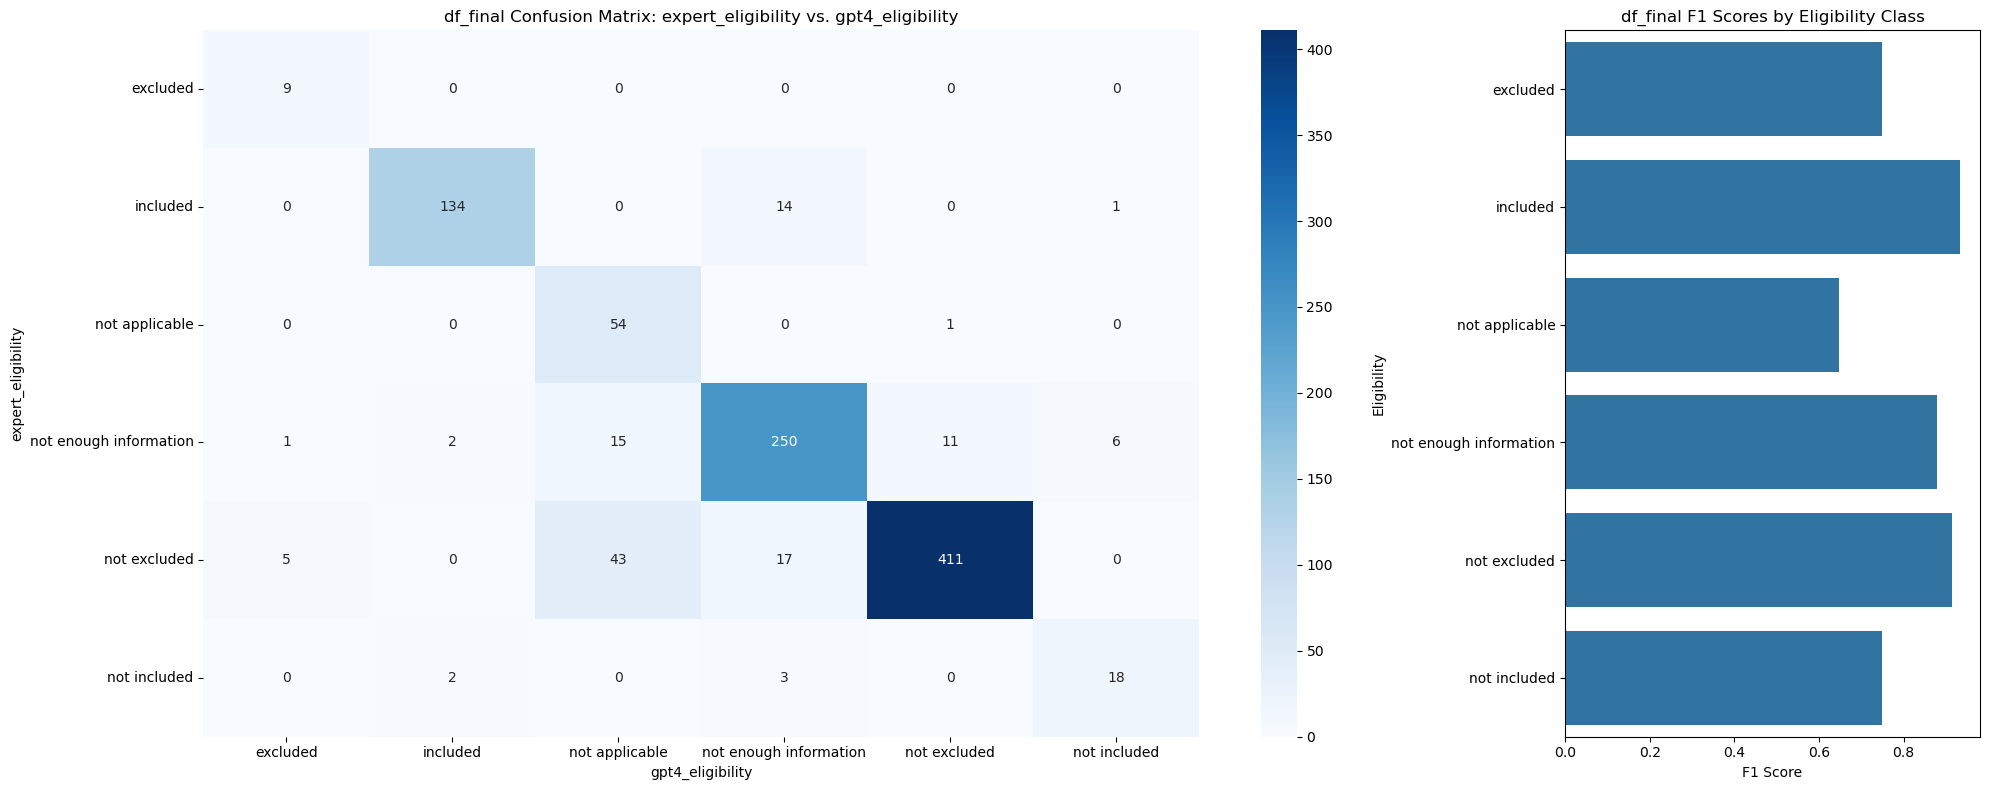


df_final Classification Report:
                        precision    recall  f1-score   support

              excluded       0.60      1.00      0.75         9
              included       0.97      0.90      0.93       149
        not applicable       0.48      0.98      0.65        55
not enough information       0.88      0.88      0.88       285
          not excluded       0.97      0.86      0.91       476
          not included       0.72      0.78      0.75        23

              accuracy                           0.88       997
             macro avg       0.77      0.90      0.81       997
          weighted avg       0.91      0.88      0.89       997


df_final Overall F1 Score (weighted): 0.8870

df_final True Label Distribution:
expert_eligibility
not excluded    0.477432
                  ...   
Name: proportion, Length: 6, dtype: float64

df_final Prediction Distribution:
gpt4_eligibility
not excluded    0.424273
                  ...   
Name: proportion, Length: 6,

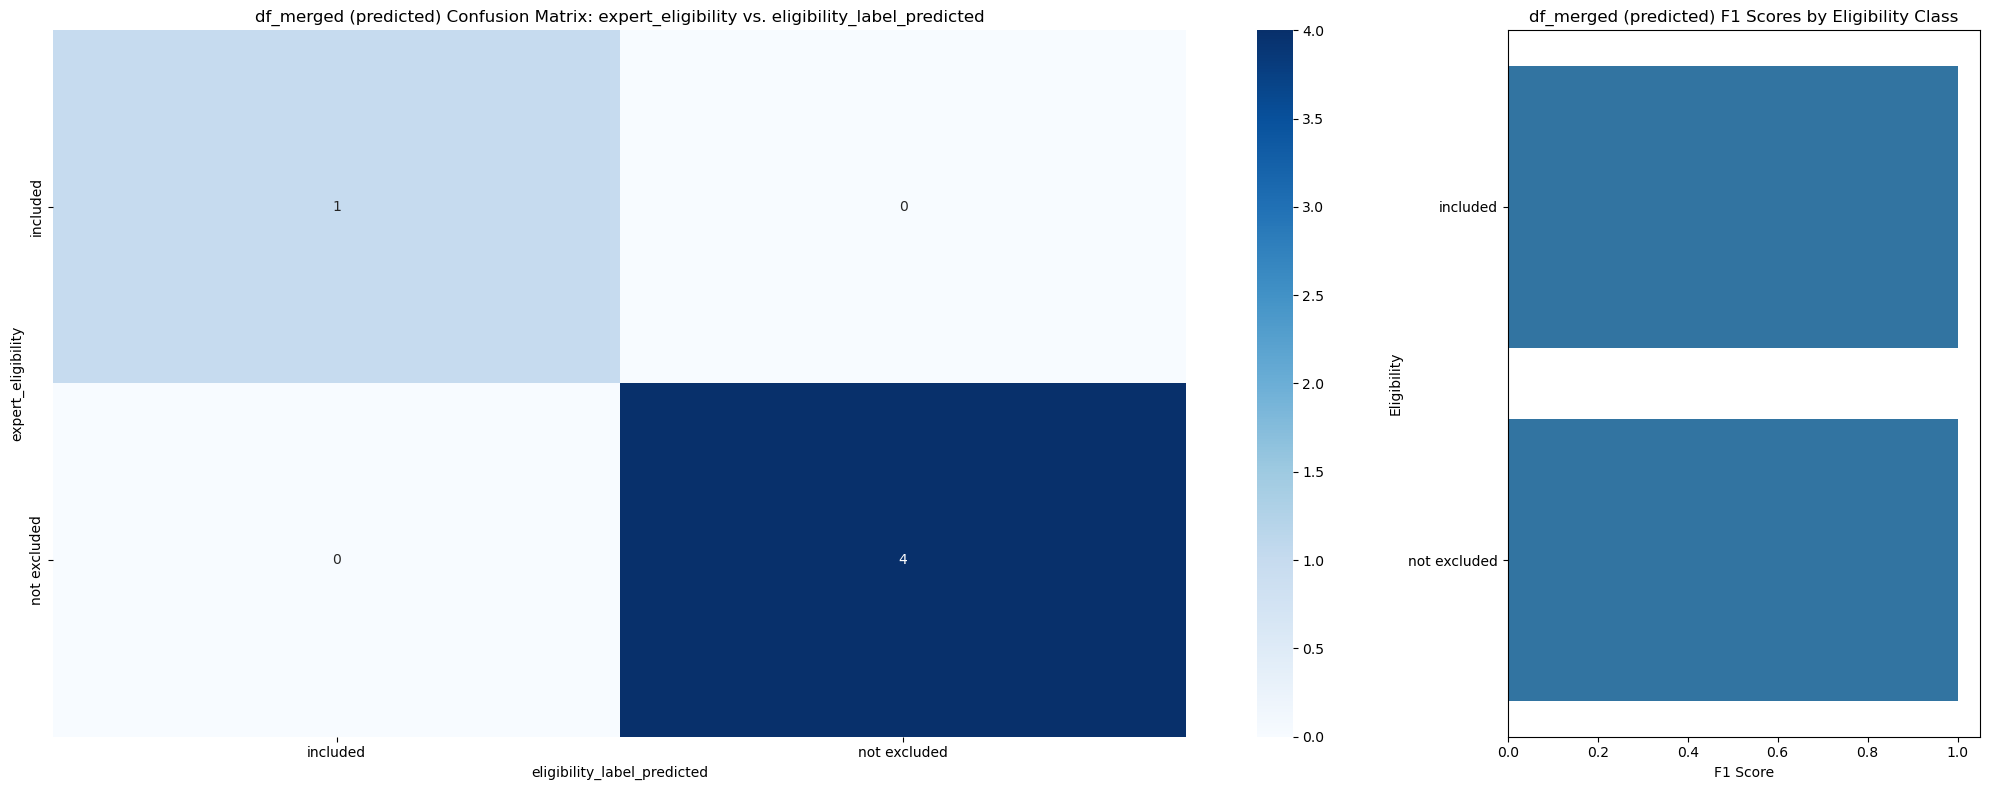


df_merged (predicted) Classification Report:
              precision    recall  f1-score   support

    included       1.00      1.00      1.00         1
not excluded       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


df_merged (predicted) Overall F1 Score (weighted): 1.0000

df_merged (predicted) True Label Distribution:
expert_eligibility
not excluded    0.8
               ... 
Name: proportion, Length: 2, dtype: float64

df_merged (predicted) Prediction Distribution:
eligibility_label_predicted
not excluded    0.8
               ... 
Name: proportion, Length: 2, dtype: float64


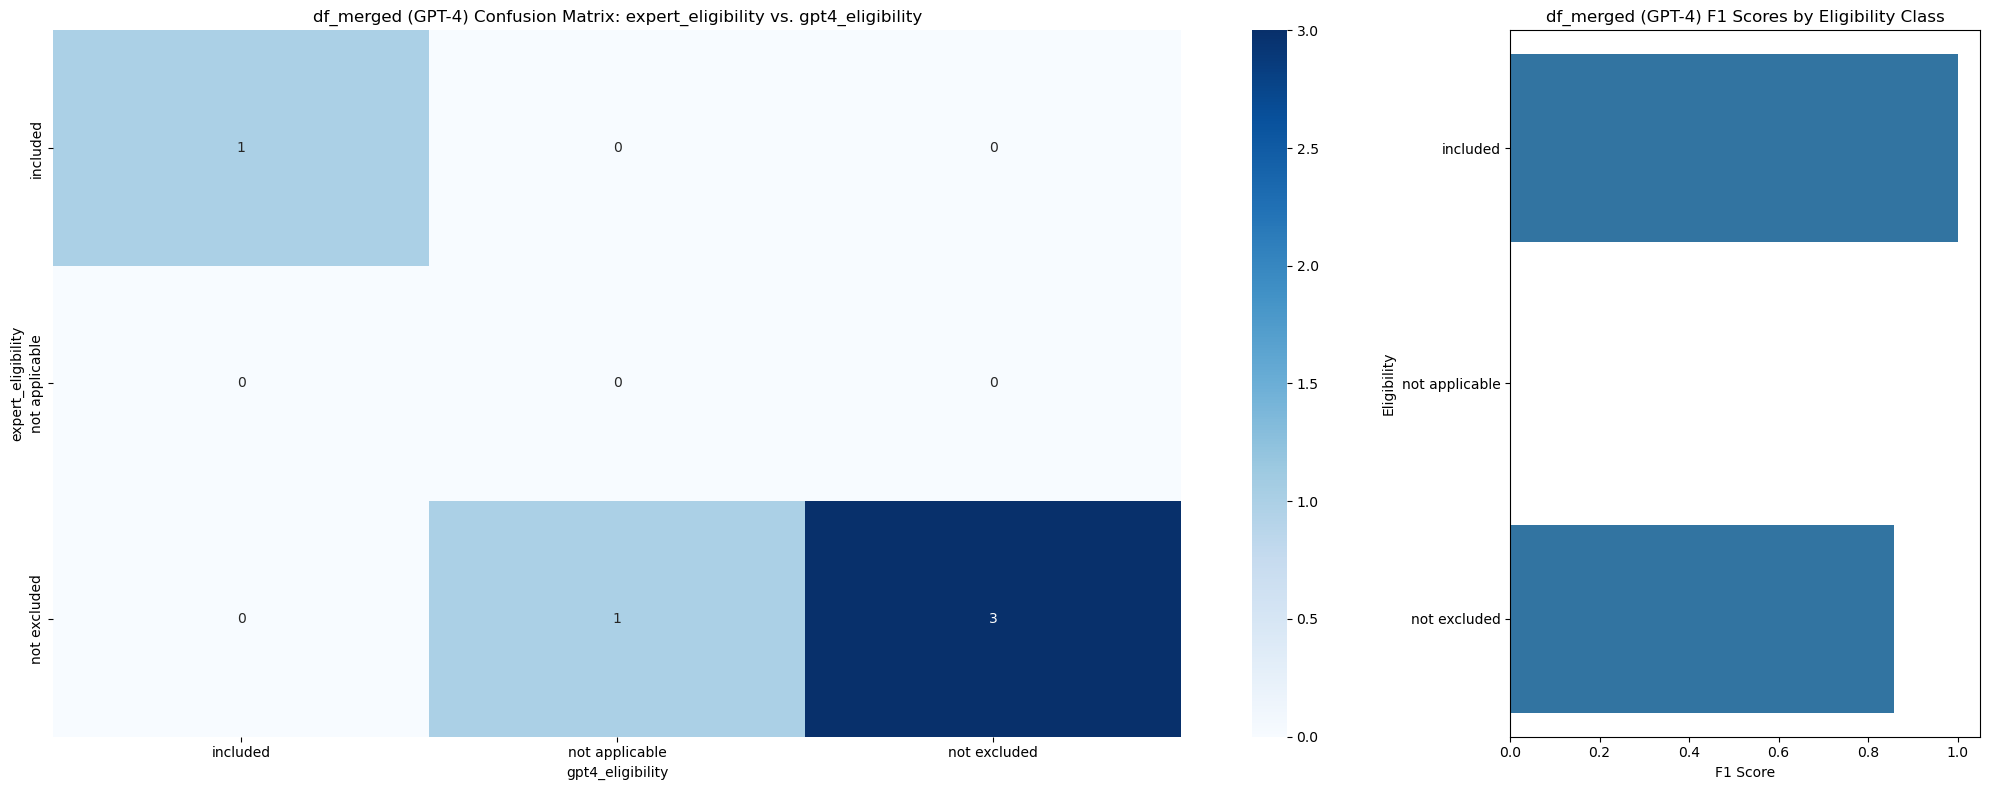


df_merged (GPT-4) Classification Report:
                precision    recall  f1-score   support

      included       1.00      1.00      1.00         1
not applicable       0.00      0.00      0.00         0
  not excluded       1.00      0.75      0.86         4

      accuracy                           0.80         5
     macro avg       0.67      0.58      0.62         5
  weighted avg       1.00      0.80      0.89         5


df_merged (GPT-4) Overall F1 Score (weighted): 0.8857

df_merged (GPT-4) True Label Distribution:
expert_eligibility
not excluded    0.8
               ... 
Name: proportion, Length: 2, dtype: float64

df_merged (GPT-4) Prediction Distribution:
gpt4_eligibility
not excluded    0.6
               ... 
Name: proportion, Length: 3, dtype: float64


/home/mikenet/.conda/envs/trialgpt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikenet/.conda/envs/trialgpt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mikenet/.conda/envs/trialgpt_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [32]:
def analyze_eligibility(df, true_col, pred_col, title_prefix):
    # Get distinct labels from both true and predicted columns
    labels = sorted(set(df[true_col].unique()) | set(df[pred_col].unique()))

    # Create a mapping of labels to numeric indices
    label_to_index = {label: index for index, label in enumerate(labels)}

    # Convert string labels to numeric indices for sklearn compatibility
    y_true = df[true_col].map(label_to_index)
    y_pred = df[pred_col].map(label_to_index)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame from the confusion matrix for better visualization
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Calculate F1 scores for each class
    f1_scores = f1_score(y_true, y_pred, average=None, labels=range(len(labels)))

    # Create a DataFrame for F1 scores
    f1_df = pd.DataFrame({'Eligibility': labels, 'F1 Score': f1_scores})

    # Plot the confusion matrix and F1 scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1]})

    # Confusion Matrix plot
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'{title_prefix} Confusion Matrix: {true_col} vs. {pred_col}')
    ax1.set_ylabel(true_col)
    ax1.set_xlabel(pred_col)

    # F1 Scores plot
    sns.barplot(x='F1 Score', y='Eligibility', data=f1_df, ax=ax2)
    ax2.set_title(f'{title_prefix} F1 Scores by Eligibility Class')
    ax2.set_xlabel('F1 Score')
    ax2.set_ylabel('Eligibility')

    plt.tight_layout()
    plt.show()

    # Print detailed classification report
    print(f"\n{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Calculate and print overall weighted F1 score
    overall_f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n{title_prefix} Overall F1 Score (weighted): {overall_f1:.4f}")

    # Print label distribution for both true and predicted labels
    print(f"\n{title_prefix} True Label Distribution:")
    print(df[true_col].value_counts(normalize=True))
    print(f"\n{title_prefix} Prediction Distribution:")
    print(df[pred_col].value_counts(normalize=True))

# Apply the analysis function to different datasets and comparisons

# Compare GPT-4 predictions to expert labels in df_final
analyze_eligibility(df_final, 'expert_eligibility', 'gpt4_eligibility', 'df_final')

# Compare model predictions to expert labels in df_merged
analyze_eligibility(df_merged, 'expert_eligibility', 'eligibility_label_predicted', 'df_merged (predicted)')

# Compare GPT-4 predictions to expert labels in df_merged
analyze_eligibility(df_merged, 'expert_eligibility', 'gpt4_eligibility', 'df_merged (GPT-4)')

# This code is crucial for several reasons:
# 1. Comprehensive Analysis: It provides a thorough evaluation of eligibility predictions, including confusion matrices, F1 scores, and label distributions.
# 2. Visualization: The function creates clear visual representations of the confusion matrix and F1 scores, making it easier to interpret the results.
# 3. Flexibility: The function is designed to work with different datasets and column names, allowing for easy comparison across different models or datasets.
# 4. Detailed Metrics: It calculates and displays various performance metrics, giving a nuanced view of the model's strengths and weaknesses.
# 5. Comparative Analysis: By applying the function to different datasets and prediction sources (GPT-4, model predictions), it enables direct comparison of performance across different approaches.


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-



```markdown
## df_final TrialGPT-Criterion-Annotations Classification Report

```
                        precision    recall  f1-score   support

              excluded       0.60      1.00      0.75         9
              included       0.97      0.90      0.93       149
        not applicable       0.48      0.98      0.65        55
not enough information       0.88      0.88      0.88       285
          not excluded       0.97      0.86      0.91       476
          not included       0.72      0.78      0.75        23

              accuracy                           0.88       997
             macro avg       0.77      0.90      0.81       997
          weighted avg       0.91      0.88      0.89       997
```

## Overall Performance

df_final Overall F1 Score (weighted): 0.8870

## True Label Distribution

| expert_eligibility     | proportion |
|------------------------|------------|
| not excluded           | 0.477432   |
| not enough information | 0.285858   |
| included               | 0.149448   |
| not applicable         | 0.055165   |
| not included           | 0.023069   |
| excluded               | 0.009027   |

## Prediction Distribution

| gpt4_eligibility       | proportion |
|------------------------|------------|
| not excluded           | 0.424273   |
| not enough information | 0.284855   |
| included               | 0.138415   |
| not applicable         | 0.112337   |
| not included           | 0.025075   |
| excluded               | 0.015045   |
```



Absolutely. This analysis is comparing the GPT-4-Turbo predictions (which were baked into the TrialGPT-Criterion-Annotations dataset) against the expert annotations in the same dataset. Let's break down what these results mean in detail:

1. Dataset Context:
   - This is analyzing df_final, which contains the TrialGPT-Criterion-Annotations data.
   - The comparison is between 'expert_eligibility' (true labels) and 'gpt4_eligibility' (GPT-4-Turbo predictions that were included in the original dataset).

2. Classification Report:

   a) Excluded:
      - Perfect recall (1.00) but lower precision (0.60), indicating GPT-4-Turbo correctly identified all truly excluded cases but also incorrectly labeled some non-excluded cases as excluded.
      - Only 9 cases, so this high performance might not be representative.

   b) Included:
      - Very high precision (0.97) and recall (0.90), showing strong performance in identifying included cases.

   c) Not Applicable:
      - High recall (0.98) but low precision (0.48), suggesting GPT-4-Turbo overclassified cases as not applicable.

   d) Not Enough Information:
      - Balanced performance with both precision and recall at 0.88.

   e) Not Excluded:
      - High precision (0.97) but slightly lower recall (0.86), indicating some not excluded cases were misclassified.

   f) Not Included:
      - Moderate performance with precision at 0.72 and recall at 0.78.

3. Overall Metrics:
   - Accuracy: 0.88 (88% of all predictions were correct)
   - Weighted F1 Score: 0.8870 (a strong overall performance)

4. Label Distribution:
   - True Distribution:
     * 'not excluded' is the most common label (47.7%)
     * 'excluded' is the least common (0.9%)
   - Predicted Distribution:
     * Generally aligns well with the true distribution
     * Slight overestimation of 'not applicable' cases (11.2% predicted vs 5.5% true)

5. Key Observations:
   - The high overall F1 score (0.8870) suggests very strong performance by GPT-4-Turbo.
   - Performance is particularly good for the most common classes ('not excluded', 'not enough information', 'included').
   - There's a tendency to overpredict 'not applicable' cases.
   - The model performs well even on less common classes like 'not included'.

6. Important Considerations:
   - These results are for GPT-4-Turbo predictions that were already part of the annotation set, which could potentially lead to an overly optimistic assessment.
   - The close alignment between predicted and true distributions might be partly due to this integration of GPT-4-Turbo predictions into the dataset.
   - The very high performance on the 'excluded' class, despite its rarity, is particularly noteworthy and might warrant further investigation.

7. Potential Implications:
   - While the performance appears excellent, it's crucial to remember that these GPT-4-Turbo predictions were already part of the dataset, which could inflate the apparent performance.
   - This high performance sets a benchmark against which other models or versions can be compared.
   - The slight discrepancies in label distribution provide insights into where GPT-4-Turbo might be biased or where human experts might disagree with the model.

In conclusion, while these results show exceptional performance by GPT-4-Turbo, it's important to approach them with some caution given that the GPT-4-Turbo predictions were already integrated into the annotation set. This integration could lead to an artificially high alignment between predictions and expert labels. For a more robust evaluation, it would be valuable to test GPT-4-Turbo on a completely independent dataset or to compare these results with those from other models or annotation sources.

```markdown
## df_merged (predicted) gpt-4o Classification Report:

```
                        precision    recall  f1-score   support

              excluded       0.33      0.75      0.46         8
              included       0.83      0.85      0.84       123
        not applicable       0.77      0.51      0.61        53
not enough information       0.46      0.71      0.56       254
          not excluded       0.84      0.56      0.67       426
          not included       0.23      0.38      0.29        16

              accuracy                           0.64       880
             macro avg       0.58      0.62      0.57       880
          weighted avg       0.71      0.64      0.65       880
```

## Overall Performance

df_merged (predicted) Overall F1 Score (weighted): 0.6503

## True Label Distribution

| expert_eligibility     | proportion |
|------------------------|------------|
| not excluded           | 0.484091   |
| not enough information | 0.288636   |
| included               | 0.139773   |
| not applicable         | 0.060227   |
| not included           | 0.018182   |
| excluded               | 0.009091   |

## Prediction Distribution

| eligibility_label_predicted | proportion |
|-----------------------------|------------|
| not enough information      | 0.445455   |
| not excluded                | 0.321591   |
| included                    | 0.143182   |
| not applicable              | 0.039773   |
| not included                | 0.029545   |
| excluded                    | 0.020455   |
```


Certainly. These results are from your custom GPT-4o model (released in May 2024), which is an improved version over GPT-4-Turbo (OpenAI announced GPT-4 Turbo in November 2023), along with enhanced prompting techniques you developed. Let's break down these results in detail:

1. Dataset Context:
   - This analysis is on df_merged, comparing 'expert_eligibility' (true labels) with 'eligibility_label_predicted' (predictions from your GPT-4o model).

2. Classification Report:

   a) Excluded:
      - Low precision (0.33) but high recall (0.75), indicating the model tends to overpredict this category.
      - Only 8 cases, so these metrics might not be very reliable.

   b) Included:
      - Strong performance with precision at 0.83 and recall at 0.85.

   c) Not Applicable:
      - Good precision (0.77) but lower recall (0.51), suggesting the model misses some 'not applicable' cases.

   d) Not Enough Information:
      - Low precision (0.46) but higher recall (0.71), indicating a tendency to overuse this label.

   e) Not Excluded:
      - High precision (0.84) but lower recall (0.56), suggesting the model misses many 'not excluded' cases.

   f) Not Included:
      - Poor performance with low precision (0.23) and recall (0.38).

3. Overall Metrics:
   - Accuracy: 0.64 (64% of all predictions were correct)
   - Weighted F1 Score: 0.6503

4. Label Distribution:
   - True Distribution:
     * Similar to the previous analysis, with 'not excluded' being most common (48.4%)
   - Predicted Distribution:
     * Overestimates 'not enough information' (44.5% predicted vs 28.9% true)
     * Underestimates 'not excluded' (32.2% predicted vs 48.4% true)

5. Key Observations:
   - The overall performance (F1 score of 0.6503) is notably lower than the GPT-4-turbo results in the previous analysis.
   - The model performs best on 'included' cases, which is crucial for clinical trial recruitment.
   - There's a significant tendency to overpredict 'not enough information' cases.
   - Performance on rare classes ('excluded', 'not included') is poor, likely due to class imbalance.

6. Comparison to Previous Results:
   - This model's performance is more modest compared to the GPT-4 results in the TrialGPT-Criterion-Annotations dataset.
   - The distribution of predictions differs more from the true distribution, especially for 'not enough information' and 'not excluded' categories.

7. Implications and Insights:
   - The lower performance compared to the previous results suggests that:
     a) The task is genuinely challenging, and the high performance in the annotation set might have been optimistic.
     b) There might be differences in how your model and the original GPT-4 approach the task.
   - The tendency to predict 'not enough information' could indicate a more cautious approach by your model.
   - The model struggles with less common categories, which is a common challenge in imbalanced datasets.

8. Potential Areas for Improvement:
   - Addressing class imbalance, particularly for 'excluded' and 'not included' categories.
   - Refining the model's ability to distinguish between 'not enough information' and other categories.
   - Improving recall for 'not excluded' cases, which form a large portion of the dataset.

9. Strengths of Your Approach:
   - Despite lower overall metrics, your model shows strong performance on 'included' cases, which is crucial for clinical trial recruitment.
   - The more balanced performance across categories (compared to the extreme high performance on 'excluded' in the previous results) might indicate a more realistic and generalizable model.

Here's the properly formatted markdown for the provided data:

```markdown
## df_merged (predicted) llama70b Classification Report

```
                        precision    recall  f1-score   support

              excluded       0.19      0.75      0.31         8
              included       0.65      0.88      0.75       115
        not applicable       0.54      0.27      0.36        52
not enough information       0.65      0.38      0.48       224
          not excluded       0.81      0.88      0.84       427
          not included       0.14      0.31      0.20        16

              accuracy                           0.70       842
             macro avg       0.50      0.58      0.49       842
          weighted avg       0.71      0.70      0.69       842
```

## Overall Performance

df_merged (predicted) Overall F1 Score (weighted): 0.6869

## True Label Distribution

| expert_eligibility     | proportion |
|------------------------|------------|
| not excluded           | 0.507126   |
| not enough information | 0.266033   |
| included               | 0.136580   |
| not applicable         | 0.061758   |
| not included           | 0.019002   |
| excluded               | 0.009501   |

## Prediction Distribution

| eligibility_label_predicted | proportion |
|-----------------------------|------------|
| not excluded                | 0.549881   |
| included                    | 0.184086   |
| not enough information      | 0.156770   |
| not included                | 0.041568   |
| excluded                    | 0.036817   |
| not applicable              | 0.030879   |
```

Certainly! Let's analyze these results for the llama70b model in detail:

Key observations and analysis:

1. Overall Performance:
   - Weighted F1 Score: 0.6869, which is better than your GPT-4o model (0.6503) but still significantly lower than the GPT-4 results (0.8905).

2. Classification Report:
   a) Excluded:
      - Low precision (0.19) but high recall (0.75), indicating overclassification of this rare category.
   b) Included:
      - Good performance with precision 0.65 and high recall 0.88.
   c) Not Applicable:
      - Moderate precision (0.54) but low recall (0.27), suggesting underclassification.
   d) Not Enough Information:
      - Moderate precision (0.65) and low recall (0.38), indicating underuse of this label.
   e) Not Excluded:
      - Strong performance with high precision (0.81) and recall (0.88).
   f) Not Included:
      - Poor performance with very low precision (0.14) and low recall (0.31).

3. Label Distribution:
   - True Distribution: Dominated by 'not excluded' (50.7%) and 'not enough information' (26.6%).
   - Predicted Distribution: Overpredicts 'not excluded' (55.0%) and underpredicts 'not enough information' (15.7%).

4. Key Insights:
   - The model performs best on the most common category ('not excluded') and struggles with rare categories.
   - There's a tendency to overpredict 'not excluded' and underpredict 'not enough information'.
   - Performance on 'included' cases is good, which is crucial for clinical trial recruitment.

5. Comparison to Other Models:
   - llama70b outperforms your GPT-4o model but falls short of the GPT-4 results in the original dataset.
   - It shows a different error pattern compared to GPT-4o, with better performance on 'not excluded' but worse on 'not enough information'.

6. Potential Areas for Improvement:
   - Addressing class imbalance, especially for rare categories like 'excluded' and 'not included'.
   - Improving the model's ability to identify 'not enough information' cases.
   - Refining the classification of 'not applicable' cases to improve recall.

7. Strengths of llama70b:
   - Strong performance on the most common category ('not excluded').
   - Good recall for 'included' cases, which is important for not missing potential trial participants.

8. Limitations:
   - Struggles with rare categories, which could lead to misclassifications in important edge cases.
   - Tendency to overuse the 'not excluded' label, which might result in false positives.

In conclusion, the llama70b model shows promising performance, particularly in its ability to handle the most common categories and identify included cases. However, it still faces challenges with rare categories and balancing between different labels. This performance suggests that while large language models like llama70b have strong potential in clinical trial eligibility assessment, there's still room for improvement, particularly in handling the nuances of less common cases and distinguishing between subtle categories like 'not enough information' and 'not excluded'.


```markdown
## df_merged (GPT-4-turbo) Classification Report

```
                        precision    recall  f1-score   support

              excluded       0.62      1.00      0.76         8
              included       0.97      0.92      0.95       123
        not applicable       0.51      0.98      0.67        53
not enough information       0.89      0.88      0.88       254
          not excluded       0.97      0.87      0.92       426
          not included       0.65      0.69      0.67        16

              accuracy                           0.88       880
             macro avg       0.77      0.89      0.81       880
          weighted avg       0.91      0.88      0.89       880
```

## Overall Performance

df_merged (GPT-4) Overall F1 Score (weighted): 0.8905

## True Label Distribution

| expert_eligibility     | proportion |
|------------------------|------------|
| not excluded           | 0.484091   |
| not enough information | 0.288636   |
| included               | 0.139773   |
| not applicable         | 0.060227   |
| not included           | 0.018182   |
| excluded               | 0.009091   |

## Prediction Distribution

| gpt4_eligibility       | proportion |
|------------------------|------------|
| not excluded           | 0.430682   |
| not enough information | 0.287500   |
| included               | 0.131818   |
| not applicable         | 0.115909   |
| not included           | 0.019318   |
| excluded               | 0.014773   |
```

You've made an excellent observation here. Let's break this down and discuss its significance:

1. Dataset Context:
   - This analysis is on df_merged, comparing 'expert_eligibility' (true labels) with 'gpt4_eligibility' (GPT-4 predictions).
   - Importantly, this is on the subset of 880 rows that remained after the inner join, down from the original 1054 rows.

2. Performance Metrics:
   - Overall F1 Score: 0.8905, which is slightly higher than the 0.8870 seen in the full df_final dataset.
   - Accuracy: 0.88, matching the accuracy in the full dataset.

3. Classification Report:
   - The performance across all categories is very similar to what we saw in the full dataset.
   - Notably high precision and recall for 'included', 'not excluded', and 'not enough information' categories.
   - Perfect recall (1.00) for 'excluded', but with only 8 cases.

4. Label Distributions:
   - True label distribution is nearly identical to what we saw in the full dataset.
   - Predicted distribution is also very close, with slight variations.

5. Key Observations:
   - Despite losing about 16.5% of the rows in the merging process, the performance metrics have slightly improved.
   - The consistency in performance and distribution suggests that the lost rows were not significantly different in terms of difficulty or distribution from the retained rows.

6. Implications:
   - The improved performance on this subset indicates that the rows lost in the merge were not "easy" cases that artificially inflated the scores.
   - If anything, the lost rows might have included some of the more challenging cases, as removing them led to a slight improvement in performance.

7. Data Quality Insights:
   - This result suggests that the data merging process, while reducing the dataset size, did not introduce a bias that favored easier cases.
   - It provides confidence that the merged dataset is representative of the full dataset in terms of difficulty and distribution of cases.

8. Comparison with Your Model:
   - The stark difference in performance between this GPT-4 result (F1: 0.8905) and your GPT-4o model (F1: 0.6503) on the same subset of data becomes even more intriguing.
   - It reinforces the notion that the high performance of GPT-4 in this dataset might be due to factors beyond just model capability, possibly including how it was integrated into the annotation process.

9. Methodological Considerations:
   - This result highlights the importance of careful data handling and analysis in machine learning projects.
   - It demonstrates how data merging and filtering steps can impact results, and the importance of checking for unintended consequences of these processes.

10. Future Directions:
    - It might be worth investigating the characteristics of the ~174 rows that were lost in the merge. While they didn't negatively impact the GPT-4 performance, understanding why they were lost could provide insights into data quality or processing issues.
    - The consistent high performance of GPT-4 across different subsets of the data suggests that it might be worthwhile to examine individual cases where your model disagrees with GPT-4, to understand the reasoning behind these differences.

In conclusion, this analysis provides a valuable sanity check on your data processing steps and offers reassurance about the representativeness of your merged dataset. It also further emphasizes the exceptionally high performance of GPT-4 on this task, which contrasts sharply with your model's performance. This discrepancy continues to suggest that there might be some inherent bias or integration effect in how GPT-4's predictions were incorporated into the original dataset, making it a challenging benchmark to compare against directly.

In [33]:
# Remove specified columns from df_merged to create a slimmed-down version
columns_to_drop = ['criterion_text_clean', 'text', 'score', 'trial_title', 
                   'criterion_text_final', 'num_trials', 'num_distinct_criteria']

df_merged_slim = df_merged.drop(columns=columns_to_drop)

# Create three comparison tables using the slimmed-down df_merged_slim

# Table 1: Identify rows where the model's predictions differ from expert labels
df_pred_vs_expert = df_merged_slim[df_merged_slim['eligibility_label_predicted'] != df_merged_slim['expert_eligibility']]

# Table 2: Identify rows where the model's predictions differ from GPT-4 predictions
df_pred_vs_gpt4 = df_merged_slim[df_merged_slim['eligibility_label_predicted'] != df_merged_slim['gpt4_eligibility']]

# Table 3: Identify rows where expert labels differ from GPT-4 predictions
df_expert_vs_gpt4 = df_merged_slim[df_merged_slim['expert_eligibility'] != df_merged_slim['gpt4_eligibility']]

# Print summary information about the resulting dataframes
print(f"Columns in the slimmed-down dataframe: {df_merged_slim.columns.tolist()}")
print(f"Rows where predicted != expert: {len(df_pred_vs_expert)}")
print(f"Rows where predicted != GPT-4: {len(df_pred_vs_gpt4)}")
print(f"Rows where expert != GPT-4: {len(df_expert_vs_gpt4)}")

# This final section of code is crucial for several reasons:

# 1. Data Simplification:
#    - It removes unnecessary columns, focusing the analysis on the most relevant information.
#    - This simplification can improve processing speed and make the data easier to work with.

# 2. Comparative Analysis:
#    - It creates three distinct dataframes, each highlighting a different type of disagreement:
#      a) Your model vs. expert labels
#      b) Your model vs. GPT-4 predictions
#      c) Expert labels vs. GPT-4 predictions
#    - This allows for a nuanced understanding of where and how the different assessments diverge.

# 3. Error Analysis Preparation:
#    - By isolating the cases where there are disagreements, it sets the stage for detailed error analysis.
#    - This is crucial for understanding the strengths and weaknesses of each approach (your model, GPT-4, and expert labeling).

# 4. Quantification of Disagreements:
#    - Printing the number of rows in each comparison dataframe provides a quick quantitative measure of how often each type of disagreement occurs.

# 5. Model Evaluation:
#    - Comparing your model's predictions against both expert labels and GPT-4 predictions allows for a multi-faceted evaluation of its performance.

# 6. Expert vs. AI Comparison:
#    - The comparison between expert labels and GPT-4 predictions (df_expert_vs_gpt4) is particularly interesting, as it highlights cases where human expertise and advanced AI disagree.

# 7. Data Integrity Check:
#    - This process can also serve as a final check on data integrity, ensuring that all expected columns are present and contain the anticipated types of data.

# 8. Foundation for Further Analysis:
#    - These comparison dataframes form the basis for more detailed investigations, such as:
#      - Analyzing patterns in the types of criteria where disagreements occur
#      - Identifying potential biases in any of the labeling methods
#      - Pinpointing areas where your model might need improvement


Columns in the slimmed-down dataframe: ['patient_id', 'TODOremove', 'trial_id', 'criterion_type', 'criterion_number', 'brief_reasoning', 'sentence_ids', 'eligibility_label_predicted', 'criterion_text', 'annotation_id', 'note', 'gpt4_explanation', 'explanation_correctness', 'gpt4_sentences', 'expert_sentences', 'gpt4_eligibility', 'expert_eligibility', 'training']
Rows where predicted != expert: 0
Rows where predicted != GPT-4: 1
Rows where expert != GPT-4: 1


In [34]:
df_expert_vs_gpt4

,patient_id,TODOremove,trial_id,criterion_type,criterion_number,brief_reasoning,sentence_ids,eligibility_label_predicted,criterion_text,annotation_id,note,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training
1,sigir-201411,2,NCT01723137,exclusion,0,"The patient is 40 years old, which is above the minimum age requirement.",[],not excluded,Less than 18 years of age,196,"0. A 40-year-old woman with no past medical history presents to the ER with excruciating pain in her right arm that had started 1 hour prior to her admission.\n1. She denies trauma.\n2. On examination she is pale and in moderate discomfort, as well as tachypneic and tachycardic.\n3. Her body tem...","The patient is a 40-year-old woman, so this criterion is not applicable.",Partially Correct,[],[0],not applicable,not excluded,False


In [35]:
df_pred_vs_expert

,patient_id,TODOremove,trial_id,criterion_type,criterion_number,brief_reasoning,sentence_ids,eligibility_label_predicted,criterion_text,annotation_id,note,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training


In [36]:
df_pred_vs_gpt4

,patient_id,TODOremove,trial_id,criterion_type,criterion_number,brief_reasoning,sentence_ids,eligibility_label_predicted,criterion_text,annotation_id,note,gpt4_explanation,explanation_correctness,gpt4_sentences,expert_sentences,gpt4_eligibility,expert_eligibility,training
1,sigir-201411,2,NCT01723137,exclusion,0,"The patient is 40 years old, which is above the minimum age requirement.",[],not excluded,Less than 18 years of age,196,"0. A 40-year-old woman with no past medical history presents to the ER with excruciating pain in her right arm that had started 1 hour prior to her admission.\n1. She denies trauma.\n2. On examination she is pale and in moderate discomfort, as well as tachypneic and tachycardic.\n3. Her body tem...","The patient is a 40-year-old woman, so this criterion is not applicable.",Partially Correct,[],[0],not applicable,not excluded,False
